In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import json
import gc

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 300)

%matplotlib inline

/home/leohmelo/venv/lib/python3.10/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/leohmelo/venv/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/leohmelo/venv/lib/python3.10/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/leohmelo/venv/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
from tqdm.notebook import tqdm
from scipy.stats import ttest_ind
from sklearn.utils import resample

---
# Data Analysis

Datasets Used: ToN-IoT, CIC-IDS and BOT-IoT.
Available at the following address: https://staff.itee.uq.edu.au/marius/NIDS_datasets/#RA8.

### ToN-IoT v2

Load dataset with just DDoS and benign data.

In [3]:
df_ton_iot_ddos = pd.read_csv('./datasets/NF-ToN-IoT-v2-DDoS.csv.gz', compression='gzip')
df_ton_iot_ddos.head()

,Unnamed: 0,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,MAX_TTL,LONGEST_FLOW_PKT,SHORTEST_FLOW_PKT,MIN_IP_PKT_LEN,MAX_IP_PKT_LEN,SRC_TO_DST_SECOND_BYTES,DST_TO_SRC_SECOND_BYTES,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,NUM_PKTS_UP_TO_128_BYTES,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Attack,Label
0,1,192.168.1.193,49228,192.168.1.152,1880,6,0.0,1600,40,35741,65,24,16,24,4294952,15,15,128,128,1286,40,40,1286,1600.0,35741.0,0,0,0,0,800000,17864000,47,3,30,19,6,16425,237,0,0,0,0,0,0,Benign,0
1,2,192.168.1.152,0,192.168.1.193,0,1,0.0,212,2,0,0,0,0,0,0,0,0,64,64,106,106,0,106,212.0,NaN,0,0,0,0,1696000,0,2,0,0,0,0,0,0,771,3,0,0,0,0,Benign,0
2,3,192.168.1.169,65317,239.255.255.250,1900,17,0.0,165,1,0,0,0,0,0,0,0,0,0,0,165,165,0,165,165.0,NaN,0,0,0,0,1320000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,Benign,0
3,4,192.168.1.79,60766,192.168.1.255,15600,17,0.0,63,1,0,0,0,0,0,0,0,0,0,0,63,63,0,63,63.0,NaN,0,0,0,0,504000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,Benign,0
4,6,192.168.1.33,0,192.168.1.193,0,1,0.0,318,3,0,0,0,0,0,0,0,0,64,64,106,106,0,106,318.0,NaN,0,0,0,0,2544000,0,3,0,0,0,0,0,0,771,3,0,0,0,0,Benign,0


In [4]:
df_ton_iot_ddos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8125703 entries, 0 to 8125702
Data columns (total 46 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Unnamed: 0                   int64  
 1   IPV4_SRC_ADDR                object 
 2   L4_SRC_PORT                  int64  
 3   IPV4_DST_ADDR                object 
 4   L4_DST_PORT                  int64  
 5   PROTOCOL                     int64  
 6   L7_PROTO                     float64
 7   IN_BYTES                     int64  
 8   IN_PKTS                      int64  
 9   OUT_BYTES                    int64  
 10  OUT_PKTS                     int64  
 11  TCP_FLAGS                    int64  
 12  CLIENT_TCP_FLAGS             int64  
 13  SERVER_TCP_FLAGS             int64  
 14  FLOW_DURATION_MILLISECONDS   int64  
 15  DURATION_IN                  int64  
 16  DURATION_OUT                 int64  
 17  MIN_TTL                      int64  
 18  MAX_TTL                      int64  
 19  

In [5]:
df_ton_iot_ddos['Attack'].unique()

array(['Benign', 'ddos'], dtype=object)

In [6]:
df_ton_iot_ddos.drop('Attack', axis=1, inplace=True)
df_ton_iot_ddos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8125703 entries, 0 to 8125702
Data columns (total 45 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Unnamed: 0                   int64  
 1   IPV4_SRC_ADDR                object 
 2   L4_SRC_PORT                  int64  
 3   IPV4_DST_ADDR                object 
 4   L4_DST_PORT                  int64  
 5   PROTOCOL                     int64  
 6   L7_PROTO                     float64
 7   IN_BYTES                     int64  
 8   IN_PKTS                      int64  
 9   OUT_BYTES                    int64  
 10  OUT_PKTS                     int64  
 11  TCP_FLAGS                    int64  
 12  CLIENT_TCP_FLAGS             int64  
 13  SERVER_TCP_FLAGS             int64  
 14  FLOW_DURATION_MILLISECONDS   int64  
 15  DURATION_IN                  int64  
 16  DURATION_OUT                 int64  
 17  MIN_TTL                      int64  
 18  MAX_TTL                      int64  
 19  

Analysis of dataset balance ToN-IoT
 - Attack (1)
 - Benign (0)

In [7]:
df_ton_iot_ddos['Label'].value_counts()

0    6099469
1    2026234
Name: Label, dtype: int64

### CSE CIC IDS 2018 v2

Load dataset with just DDoS and benign data.

In [8]:
df_cic_ids_ddos = pd.read_csv('./datasets/NF-CSE-CIC-IDS2018-v2-DDoS.csv.gz', compression='gzip')
df_cic_ids_ddos.head()

,Unnamed: 0,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,MAX_TTL,LONGEST_FLOW_PKT,SHORTEST_FLOW_PKT,MIN_IP_PKT_LEN,MAX_IP_PKT_LEN,SRC_TO_DST_SECOND_BYTES,DST_TO_SRC_SECOND_BYTES,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,NUM_PKTS_UP_TO_128_BYTES,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack
0,1,213.202.230.143,29622,172.31.66.103,3389,6,0.0,1919,14,2031,11,223,219,30,0,0,0,101,101,1195,40,40,1195,1919.0,2031.0,0,0,0,0,15352000,16248000,17,6,0,1,1,8192,64000,0,0,0,0,0,0,0,Benign
1,2,172.31.66.5,65456,172.31.0.2,53,17,0.0,116,2,148,2,0,0,0,0,0,0,128,128,74,58,58,74,116.0,148.0,0,0,0,0,928000,1184000,4,0,0,0,0,0,0,0,0,2511,1,5,0,0,Benign
2,3,172.31.64.92,57918,172.31.0.2,53,17,0.0,70,1,130,1,0,0,0,0,0,0,0,0,130,70,70,130,70.0,130.0,0,0,0,0,560000,1040000,1,1,0,0,0,0,0,0,0,3371,1,60,0,0,Benign
3,4,18.219.32.43,63269,172.31.69.25,80,6,7.0,232,5,1136,4,223,222,27,4294827,140,0,127,127,1004,40,40,1004,232.0,1136.0,0,0,0,0,8000,9088000,8,0,0,1,0,8192,26883,0,0,0,0,0,0,1,DDoS attacks-LOIC-HTTP
4,5,172.31.65.93,51677,23.36.33.52,443,6,0.0,3988,41,3169,40,223,223,30,0,0,0,128,128,671,40,40,671,3988.0,3169.0,1148,28,0,0,31904000,25352000,73,1,3,4,0,8192,29200,31744,124,0,0,0,0,0,Benign


In [9]:
df_cic_ids_ddos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18025837 entries, 0 to 18025836
Data columns (total 46 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Unnamed: 0                   int64  
 1   IPV4_SRC_ADDR                object 
 2   L4_SRC_PORT                  int64  
 3   IPV4_DST_ADDR                object 
 4   L4_DST_PORT                  int64  
 5   PROTOCOL                     int64  
 6   L7_PROTO                     float64
 7   IN_BYTES                     int64  
 8   IN_PKTS                      int64  
 9   OUT_BYTES                    int64  
 10  OUT_PKTS                     int64  
 11  TCP_FLAGS                    int64  
 12  CLIENT_TCP_FLAGS             int64  
 13  SERVER_TCP_FLAGS             int64  
 14  FLOW_DURATION_MILLISECONDS   int64  
 15  DURATION_IN                  int64  
 16  DURATION_OUT                 int64  
 17  MIN_TTL                      int64  
 18  MAX_TTL                      int64  
 19

In [10]:
df_cic_ids_ddos['Attack'].unique()

array(['Benign', 'DDoS attacks-LOIC-HTTP', 'DDOS attack-HOIC',
       'DDOS attack-LOIC-UDP'], dtype=object)

In [12]:
df_cic_ids_ddos['IPV4_DST_ADDR'].value_counts()

172.31.0.2         7544830
172.31.69.28       1087726
169.254.169.254     451625
172.31.69.25        308633
72.21.91.29          83109
                    ...   
103.65.41.154            1
61.144.42.34             1
54.187.95.238            1
204.237.229.70           1
172.217.24.99            1
Name: IPV4_DST_ADDR, Length: 33579, dtype: int64

In [13]:
df_cic_ids_ddos.drop('Attack', axis=1, inplace=True)
df_cic_ids_ddos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18025837 entries, 0 to 18025836
Data columns (total 45 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Unnamed: 0                   int64  
 1   IPV4_SRC_ADDR                object 
 2   L4_SRC_PORT                  int64  
 3   IPV4_DST_ADDR                object 
 4   L4_DST_PORT                  int64  
 5   PROTOCOL                     int64  
 6   L7_PROTO                     float64
 7   IN_BYTES                     int64  
 8   IN_PKTS                      int64  
 9   OUT_BYTES                    int64  
 10  OUT_PKTS                     int64  
 11  TCP_FLAGS                    int64  
 12  CLIENT_TCP_FLAGS             int64  
 13  SERVER_TCP_FLAGS             int64  
 14  FLOW_DURATION_MILLISECONDS   int64  
 15  DURATION_IN                  int64  
 16  DURATION_OUT                 int64  
 17  MIN_TTL                      int64  
 18  MAX_TTL                      int64  
 19

Analysis of dataset Balance CIC-IDS.
 - Benign (0)
 - Attack (1)

In [14]:
df_cic_ids_ddos['Label'].value_counts() # this dataset contains ALL benign plus those with DDoS

0    16635567
1     1390270
Name: Label, dtype: int64

### BoT-IoT v2

Load dataset with just DDoS and benign data.

In [15]:
df_bot_iot_ddos = pd.read_csv('./datasets/NF-BoT-IoT-v2-DDoS.csv.gz', compression='gzip')
df_bot_iot_ddos.head()

,Unnamed: 0,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,MAX_TTL,LONGEST_FLOW_PKT,SHORTEST_FLOW_PKT,MIN_IP_PKT_LEN,MAX_IP_PKT_LEN,SRC_TO_DST_SECOND_BYTES,DST_TO_SRC_SECOND_BYTES,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,NUM_PKTS_UP_TO_128_BYTES,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack
0,3,192.168.100.147,52113,192.168.100.7,80,17,188.0,56,2,0,0,0,0,0,4294545,422,0,64,64,28,28,0,28,56.0,0.0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,DDoS
1,4,192.168.100.150,36780,192.168.100.6,80,17,188.0,56,2,0,0,0,0,0,4293732,1235,0,64,64,28,28,0,28,2828.0,0.0,0,0,0,0,224000,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,DDoS
2,5,192.168.100.148,61749,192.168.100.7,80,17,188.0,84,3,0,0,0,0,0,4293826,1141,0,64,64,28,28,0,28,2856.0,0.0,0,0,0,0,224000,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,DDoS
3,7,192.168.100.149,59453,192.168.100.6,80,17,188.0,56,2,0,0,0,0,0,4294502,465,0,64,64,28,28,0,28,56.0,0.0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,DDoS
4,10,192.168.100.148,29148,192.168.100.3,80,17,188.0,56,2,0,0,0,0,0,4293656,1311,0,64,64,28,28,0,28,2828.0,0.0,0,0,0,0,224000,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,DDoS


In [16]:
df_bot_iot_ddos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18466884 entries, 0 to 18466883
Data columns (total 46 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Unnamed: 0                   int64  
 1   IPV4_SRC_ADDR                object 
 2   L4_SRC_PORT                  int64  
 3   IPV4_DST_ADDR                object 
 4   L4_DST_PORT                  int64  
 5   PROTOCOL                     int64  
 6   L7_PROTO                     float64
 7   IN_BYTES                     int64  
 8   IN_PKTS                      int64  
 9   OUT_BYTES                    int64  
 10  OUT_PKTS                     int64  
 11  TCP_FLAGS                    int64  
 12  CLIENT_TCP_FLAGS             int64  
 13  SERVER_TCP_FLAGS             int64  
 14  FLOW_DURATION_MILLISECONDS   int64  
 15  DURATION_IN                  int64  
 16  DURATION_OUT                 int64  
 17  MIN_TTL                      int64  
 18  MAX_TTL                      int64  
 19

In [17]:
df_bot_iot_ddos['Attack'].unique()

array(['DDoS', 'Benign'], dtype=object)

Analysis of dataset Balance BoT-IoT.
 - Benign (0)
 - Attack (1)

In [18]:
df_bot_iot_ddos['Attack'].value_counts()

DDoS      18331847
Benign      135037
Name: Attack, dtype: int64

In [19]:
df_bot_iot_ddos.drop('Attack', axis=1, inplace=True)
df_bot_iot_ddos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18466884 entries, 0 to 18466883
Data columns (total 45 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Unnamed: 0                   int64  
 1   IPV4_SRC_ADDR                object 
 2   L4_SRC_PORT                  int64  
 3   IPV4_DST_ADDR                object 
 4   L4_DST_PORT                  int64  
 5   PROTOCOL                     int64  
 6   L7_PROTO                     float64
 7   IN_BYTES                     int64  
 8   IN_PKTS                      int64  
 9   OUT_BYTES                    int64  
 10  OUT_PKTS                     int64  
 11  TCP_FLAGS                    int64  
 12  CLIENT_TCP_FLAGS             int64  
 13  SERVER_TCP_FLAGS             int64  
 14  FLOW_DURATION_MILLISECONDS   int64  
 15  DURATION_IN                  int64  
 16  DURATION_OUT                 int64  
 17  MIN_TTL                      int64  
 18  MAX_TTL                      int64  
 19

## Analysis from data to generate silos with high amount of ddos_attacks

Devices Ip which received DDoS attacks.

In [20]:
# Targets of DDoS machines ToN-IoT Packets Amount
attack_label = [1]
df_ton_iot_ddos[df_ton_iot_ddos['Label'].isin(attack_label)]['IPV4_DST_ADDR'].value_counts()

192.168.1.184     1485720
192.168.1.194      305973
192.168.1.152       95333
192.168.1.190       91243
192.168.1.1         38160
192.168.1.195        5187
176.28.50.165        2838
52.59.177.21          631
18.184.104.180        504
192.168.1.193         242
192.168.1.180         208
128.30.52.21           23
101.119.11.17          23
101.119.11.11          20
216.239.32.21          16
216.239.34.21          11
54.230.136.147         11
216.239.38.21          11
54.230.136.185         10
54.230.136.10           7
117.18.237.29           6
13.35.99.71             6
13.35.99.107            6
216.239.36.21           6
216.58.200.110          6
54.230.136.77           6
13.35.99.104            5
13.35.99.5              4
54.230.84.198           3
52.24.56.107            3
52.26.235.130           2
54.230.84.124           2
54.230.84.165           2
74.125.69.136           1
74.125.69.91            1
34.223.203.249          1
54.230.84.22            1
220.158.215.20          1
192.168.1.30

In [21]:
# Targets of DDoS machines CIC-IDS
attack_label = [1]
df_cic_ids_ddos[df_cic_ids_ddos['Label'].isin(attack_label)]['IPV4_DST_ADDR'].value_counts()

172.31.69.28    1082970
172.31.69.25     307300
Name: IPV4_DST_ADDR, dtype: int64

In [22]:
# Targets of DDoS machines BoT-IoT
attack_label = [1]
df_bot_iot_ddos[df_bot_iot_ddos['Label'].isin(attack_label)]['IPV4_DST_ADDR'].value_counts()

192.168.100.3      8815480
192.168.100.5      4308860
192.168.100.7      2831589
192.168.100.6      2371793
192.168.100.149       1087
192.168.100.147       1070
192.168.100.148       1028
192.168.100.150        940
Name: IPV4_DST_ADDR, dtype: int64

## Filtering ddos attacks to keep top targets

In [23]:
# Devices with traffic greater than 3k flow samples
ton_iot_top = [
    '192.168.1.184', '192.168.1.49', '192.168.1.180', 
    '192.168.1.194', '192.168.1.195', '192.168.1.190', 
    '192.168.1.152', '192.168.1.193', '192.168.1.169', 
    '192.168.1.46', '192.168.1.186', '192.168.1.79', 
    '192.168.1.1', '192.168.1.133', '192.168.1.250', 
    '176.28.50.165'
]

In [24]:
# filter dataframe for top DDoS IP destinations (considering DDoS traffic)
df_ton_iot_top = df_ton_iot_ddos[df_ton_iot_ddos['IPV4_DST_ADDR'].isin(ton_iot_top)].copy()
df_ton_iot_top.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7360408 entries, 0 to 8125702
Data columns (total 45 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Unnamed: 0                   int64  
 1   IPV4_SRC_ADDR                object 
 2   L4_SRC_PORT                  int64  
 3   IPV4_DST_ADDR                object 
 4   L4_DST_PORT                  int64  
 5   PROTOCOL                     int64  
 6   L7_PROTO                     float64
 7   IN_BYTES                     int64  
 8   IN_PKTS                      int64  
 9   OUT_BYTES                    int64  
 10  OUT_PKTS                     int64  
 11  TCP_FLAGS                    int64  
 12  CLIENT_TCP_FLAGS             int64  
 13  SERVER_TCP_FLAGS             int64  
 14  FLOW_DURATION_MILLISECONDS   int64  
 15  DURATION_IN                  int64  
 16  DURATION_OUT                 int64  
 17  MIN_TTL                      int64  
 18  MAX_TTL                      int64  
 19  

In [25]:
del df_ton_iot_ddos

In [26]:
gc.collect()

0

CIC-IDS

In [27]:
# Count the number of packets for each device
cic_ids_device_samples_count = df_cic_ids_ddos['IPV4_DST_ADDR'].value_counts().to_dict()

In [28]:
# Devices that have both attack and benign classes
top_cic_ids = ["172.31.69.28", "172.31.69.25"]

In [29]:
# Filter dataframe for top DDoS IP destinations (considering DDoS traffic)
df_cic_ids_top = df_cic_ids_ddos[df_cic_ids_ddos['IPV4_DST_ADDR'].isin(top_cic_ids)]
df_cic_ids_top.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1396359 entries, 3 to 18025834
Data columns (total 45 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   Unnamed: 0                   1396359 non-null  int64  
 1   IPV4_SRC_ADDR                1396359 non-null  object 
 2   L4_SRC_PORT                  1396359 non-null  int64  
 3   IPV4_DST_ADDR                1396359 non-null  object 
 4   L4_DST_PORT                  1396359 non-null  int64  
 5   PROTOCOL                     1396359 non-null  int64  
 6   L7_PROTO                     1396359 non-null  float64
 7   IN_BYTES                     1396359 non-null  int64  
 8   IN_PKTS                      1396359 non-null  int64  
 9   OUT_BYTES                    1396359 non-null  int64  
 10  OUT_PKTS                     1396359 non-null  int64  
 11  TCP_FLAGS                    1396359 non-null  int64  
 12  CLIENT_TCP_FLAGS             1396359 non-

In [30]:
del df_cic_ids_ddos

In [31]:
gc.collect()

0

BoT-IoT

In [32]:
# Count the number of packets for each device
bot_iot_device_samples_count = df_bot_iot_ddos['IPV4_DST_ADDR'].value_counts().to_dict()

In [33]:
# Filters devices with over 3000 samples
top_bot_iot = list(
    filter(
        lambda sample: bot_iot_device_samples_count[sample] >= 2e3, 
        bot_iot_device_samples_count.keys()
    )
)
print(top_bot_iot)

['192.168.100.3', '192.168.100.5', '192.168.100.7', '192.168.100.6', '192.168.100.148', '192.168.100.149', '192.168.100.150', '192.168.100.147', '192.168.159.152']


In [34]:
df_bot_iot_top = df_bot_iot_ddos[df_bot_iot_ddos['IPV4_DST_ADDR'].isin(top_bot_iot)]
df_bot_iot_top.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18460837 entries, 0 to 18466883
Data columns (total 45 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Unnamed: 0                   int64  
 1   IPV4_SRC_ADDR                object 
 2   L4_SRC_PORT                  int64  
 3   IPV4_DST_ADDR                object 
 4   L4_DST_PORT                  int64  
 5   PROTOCOL                     int64  
 6   L7_PROTO                     float64
 7   IN_BYTES                     int64  
 8   IN_PKTS                      int64  
 9   OUT_BYTES                    int64  
 10  OUT_PKTS                     int64  
 11  TCP_FLAGS                    int64  
 12  CLIENT_TCP_FLAGS             int64  
 13  SERVER_TCP_FLAGS             int64  
 14  FLOW_DURATION_MILLISECONDS   int64  
 15  DURATION_IN                  int64  
 16  DURATION_OUT                 int64  
 17  MIN_TTL                      int64  
 18  MAX_TTL                      int64  
 19

In [35]:
del df_bot_iot_ddos

In [36]:
gc.collect()

0

## Subset of applicable agents/silos (_feasible_agents_) - ToN-IoT

In [37]:
# Choose the feasible agents according to the ddos/normal balance (dst addr with both normal and ddos flow samples)

feasible_agents = [
    '192.168.1.184', '192.168.1.180', '192.168.1.194', 
    '192.168.1.195', '192.168.1.190', '192.168.1.152', 
    '192.168.1.193', '192.168.1.1', '176.28.50.165'
]

df_ton_iot_top = df_ton_iot_top[df_ton_iot_top['IPV4_DST_ADDR'].isin(feasible_agents)]
df_ton_iot_top.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5037300 entries, 0 to 8125702
Data columns (total 45 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Unnamed: 0                   int64  
 1   IPV4_SRC_ADDR                object 
 2   L4_SRC_PORT                  int64  
 3   IPV4_DST_ADDR                object 
 4   L4_DST_PORT                  int64  
 5   PROTOCOL                     int64  
 6   L7_PROTO                     float64
 7   IN_BYTES                     int64  
 8   IN_PKTS                      int64  
 9   OUT_BYTES                    int64  
 10  OUT_PKTS                     int64  
 11  TCP_FLAGS                    int64  
 12  CLIENT_TCP_FLAGS             int64  
 13  SERVER_TCP_FLAGS             int64  
 14  FLOW_DURATION_MILLISECONDS   int64  
 15  DURATION_IN                  int64  
 16  DURATION_OUT                 int64  
 17  MIN_TTL                      int64  
 18  MAX_TTL                      int64  
 19  

## Check the balance between ddos and normal for top ddos targets
> Labels references
>
> Attack == 1,
> Benign == 0

ToN-IoT

In [38]:
df_ton_iot_top['Label'].value_counts()

0    3012396
1    2024904
Name: Label, dtype: int64

In [39]:
target_balance_ton_iot = df_ton_iot_top[['IPV4_DST_ADDR', 'Label']].copy()
target_balance_ton_iot = pd.get_dummies(target_balance_ton_iot, columns=['Label'])
target_balance_ton_iot.groupby('IPV4_DST_ADDR').sum()

,Label_0,Label_1
IPV4_DST_ADDR,,
176.28.50.165,1424.0,2838.0
192.168.1.1,63982.0,38160.0
192.168.1.152,282044.0,95333.0
192.168.1.180,721573.0,208.0
192.168.1.184,64909.0,1485720.0
192.168.1.190,623891.0,91243.0
192.168.1.193,336907.0,242.0
192.168.1.194,296947.0,305973.0
192.168.1.195,620719.0,5187.0


In [40]:
del target_balance_ton_iot

In [41]:
gc.collect()

0

CIC IDS

In [42]:
df_cic_ids_top['Label'].value_counts()

1    1390270
0       6089
Name: Label, dtype: int64

In [43]:
target_balance_cic_ids = df_cic_ids_top[['IPV4_DST_ADDR', 'Label']].copy()
target_balance_cic_ids = pd.get_dummies(target_balance_cic_ids, columns=['Label'])
target_balance_cic_ids.groupby('IPV4_DST_ADDR').sum()

,Label_0,Label_1
IPV4_DST_ADDR,,
172.31.69.25,1333.0,307300.0
172.31.69.28,4756.0,1082970.0


In [44]:
del target_balance_cic_ids
gc.collect()

0

BoT-IoT

In [45]:
df_bot_iot_top['Label'].value_counts()

1    18331847
0      128990
Name: Label, dtype: int64

In [46]:
target_balance_bot_iot = df_bot_iot_top[['IPV4_DST_ADDR', 'Label']].copy()
target_balance_bot_iot = pd.get_dummies(target_balance_bot_iot, columns=['Label'])
target_balance_bot_iot.groupby('IPV4_DST_ADDR').sum()

,Label_0,Label_1
IPV4_DST_ADDR,,
192.168.100.147,19262.0,1070.0
192.168.100.148,23712.0,1028.0
192.168.100.149,21063.0,1087.0
192.168.100.150,20521.0,940.0
192.168.100.3,31111.0,8815480.0
192.168.100.5,3697.0,4308860.0
192.168.100.6,3188.0,2371793.0
192.168.100.7,3857.0,2831589.0
192.168.159.152,2579.0,0.0


In [47]:
del target_balance_bot_iot
gc.collect()

0

## Remove not applicable features

In [48]:
remove_columns = ['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO']

ToN-IoT

In [49]:
df_ton_iot_hist = df_ton_iot_top.loc[:, ~df_ton_iot_top.columns.isin(remove_columns)].copy()
df_ton_iot_hist.describe()

,Unnamed: 0,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,MAX_TTL,LONGEST_FLOW_PKT,SHORTEST_FLOW_PKT,MIN_IP_PKT_LEN,MAX_IP_PKT_LEN,SRC_TO_DST_SECOND_BYTES,DST_TO_SRC_SECOND_BYTES,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,NUM_PKTS_UP_TO_128_BYTES,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label
count,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06,5037300.0,3439374.0,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06,5.037300e+06
mean,8.651954e+06,1.023967e+03,7.553462e+00,7.954128e+02,4.279934e+00,1.407838e+01,9.656500e+00,1.280686e+01,1.314374e+06,5.578994e+01,5.531766e+01,2.950378e+01,2.951420e+01,1.521140e+02,5.001173e+01,3.394806e+01,1.521140e+02,inf,inf,5.970150e+00,2.087031e-02,1.500719e+02,4.665662e-01,1.316047e+06,9.620499e+05,2.838361e+02,4.540605e-01,7.283956e-01,2.115891e-01,4.413678e-01,1.278593e+04,1.045469e+04,1.791009e+02,6.996123e-01,2.289814e+03,2.375147e-01,1.207198e+04,1.479745e-01,4.019820e-01
std,4.808204e+06,2.584791e+05,7.219380e+02,1.200356e+05,3.990169e+02,1.013768e+01,9.853868e+00,1.039886e+01,1.979232e+06,2.230277e+02,1.979962e+02,3.314001e+01,3.316031e+01,3.470818e+02,2.720481e+01,2.429279e+01,3.470818e+02,NaN,NaN,2.391203e+03,7.936784e+00,1.014775e+03,2.541901e+00,1.252248e+07,1.391132e+07,5.803450e+03,4.204171e+01,3.769959e+01,3.510674e+01,1.719746e+02,1.439263e+04,1.384134e+04,2.840793e+03,1.109685e+01,9.816983e+03,2.083071e+00,8.364069e+04,7.895590e+00,4.902984e-01
min,1.000000e+00,4.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.800000e+01,2.800000e+01,0.000000e+00,2.800000e+01,28.0,28.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.844888e+06,4.400000e+01,1.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01,4.400000e+01,0.000000e+00,4.400000e+01,44.0,40.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.520000e+05,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.024000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.265594e+06,5.400000e+01,1.000000e+00,4.000000e+01,1.000000e+00,1.900000e+01,2.000000e+00,1.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01,4.400000e+01,4.000000e+01,4.400000e+01,54.0,112.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.520000e+05,5.600000e+04,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.024000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.324860e+07,2.240000e+02,4.000000e+00,1.720000e+02,3.000000e+00,2.200000e+01,1.800000e+01,2.000000e+01,4.294577e+06,1.600000e+01,1.600000e+01,6.400000e+01,6.400000e+01,6.000000e+01,5.200000e+01,5.200000e+01,6.000000e+01,268.0,323.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.720000e+05,3.200000e+05,7.000000e+00,0.000000e+00,0.00

Label
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: IN_PKTS, dtype: object

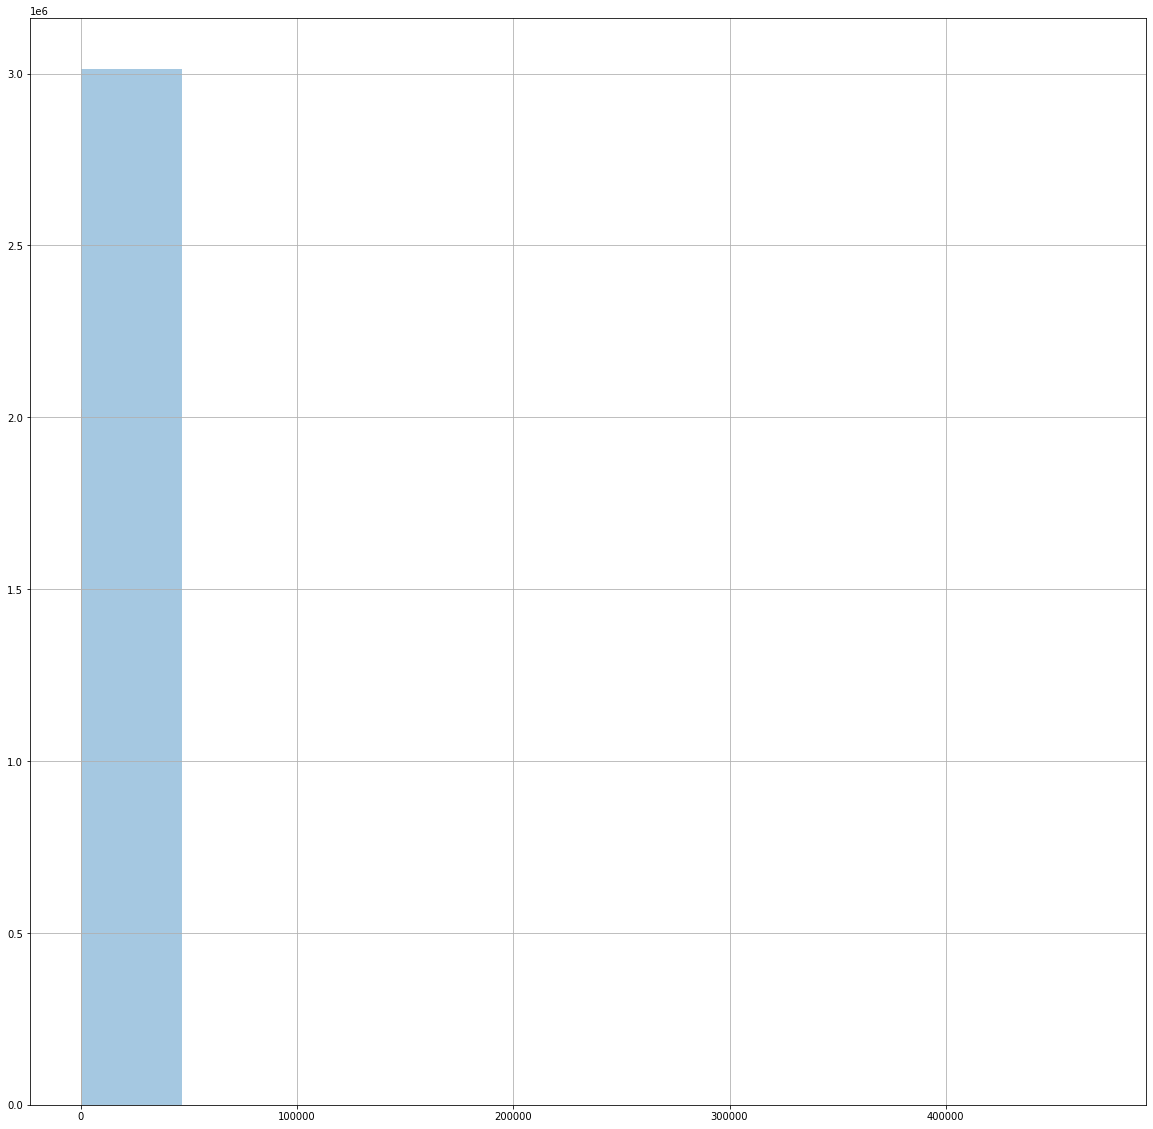

In [50]:
# Deal with inf and NaN
df_ton_iot_hist.fillna(0)
df_ton_iot_hist.replace(np.inf, 9999, inplace=True)
df_ton_iot_hist.groupby("Label").IN_PKTS.hist(alpha=0.4, figsize=(20,20))

In [51]:
del df_ton_iot_hist
gc.collect()

0

CIC IDS

In [52]:
df_cic_ids_hist = df_cic_ids_top.loc[:, ~df_cic_ids_top.columns.isin(remove_columns)]
df_cic_ids_hist.describe()

,Unnamed: 0,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,MAX_TTL,LONGEST_FLOW_PKT,SHORTEST_FLOW_PKT,MIN_IP_PKT_LEN,MAX_IP_PKT_LEN,SRC_TO_DST_SECOND_BYTES,DST_TO_SRC_SECOND_BYTES,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,NUM_PKTS_UP_TO_128_BYTES,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label
count,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1.396359e+06,1396359.0,1396359.0,1.396359e+06
mean,9.448638e+06,1.312473e+04,2.162037e+02,1.119717e+03,4.692314e+00,2.146332e+02,2.144075e+02,2.644916e+01,4.139920e+06,1.991972e+02,3.873044e+01,1.258737e+02,1.258769e+02,9.593432e+02,4.032913e+01,3.914000e+01,9.593432e+02,4.722214e+298,2.235876e+67,8.307162e-01,2.472144e-03,3.145008e-01,7.247420e-04,5.387397e+05,2.355533e+06,2.191351e+02,4.219545e-03,7.780664e-01,9.766922e-01,1.920710e-03,5.244502e+04,2.631311e+04,5.278090e+01,2.061741e-01,1.243226e-01,1.496750e-03,0.0,0.0,9.956394e-01
std,5.454990e+06,2.391221e+05,3.985503e+03,1.819587e+02,8.552183e-01,3.268031e+01,3.278433e+01,4.367957e+00,8.006477e+05,3.796704e+03,1.583126e+02,1.191299e+01,1.191422e+01,1.416537e+02,4.701751e+00,5.826253e+00,1.416537e+02,inf,2.642082e+70,2.123450e+01,6.184888e-02,2.295218e+01,4.741499e-02,1.989723e+06,3.258967e+06,3.985348e+03,1.184369e-01,4.228519e-01,1.553598e-01,4.901602e-02,2.429201e+04,4.262147e+03,1.339685e+03,5.233146e+00,4.814486e+01,6.108107e-01,0.0,0.0,6.589093e-02
min,4.000000e+00,2.800000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.800000e+01,2.800000e+01,0.000000e+00,2.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00
25%,4.728942e+06,4.610000e+02,5.000000e+00,1.147000e+03,5.000000e+00,2.190000e+02,2.190000e+02,2.700000e+01,4.294916e+06,6.000000e+00,3.000000e+00,1.270000e+02,1.270000e+02,9.750000e+02,4.000000e+01,4.000000e+01,9.750000e+02,4.610000e+02,1.147000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.200000e+04,2.560000e+05,8.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,6.553500e+04,2.688300e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,1.000000e+00
50%,9.449793e+06,5.030000e+02,5.000000e+00,1.147000e+03,5.000000e+00,2.190000e+02,2.190000e+02,2.700000e+01,4.294941e+06,2.300000e+01,1.100000e+01,1.270000e+02,1.270000e+02,9.750000e+02,4.000000e+01,4.000000e+01,9.750000e+02,5.100000e+02,1.147000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.680000e+05,7.040000e+05,8.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,6.553500e+04,2.688300e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,1.000000e+00
75%,1.417738e+07,5.270000e+02,5.000000e+00,1.147000e+03,5.000000e+00,2.190000e+02,2.190000e+02,2.700000e+01,4.294959e+06,4.700000e+01,3.300000e+01,1.270000e+02,1.270000e+02,9.750000e+02,4.000000e+01,4.000000e+01,9.750000e+02,5.280000e+02,1.147000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.960000e+05,2.288000e+06,8.000000e+00,0.000000e+00,1.000

/tmp/ipykernel_2502063/2736462699.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cic_ids_hist.replace(np.inf, 9999, inplace=True)


Label
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: IN_PKTS, dtype: object

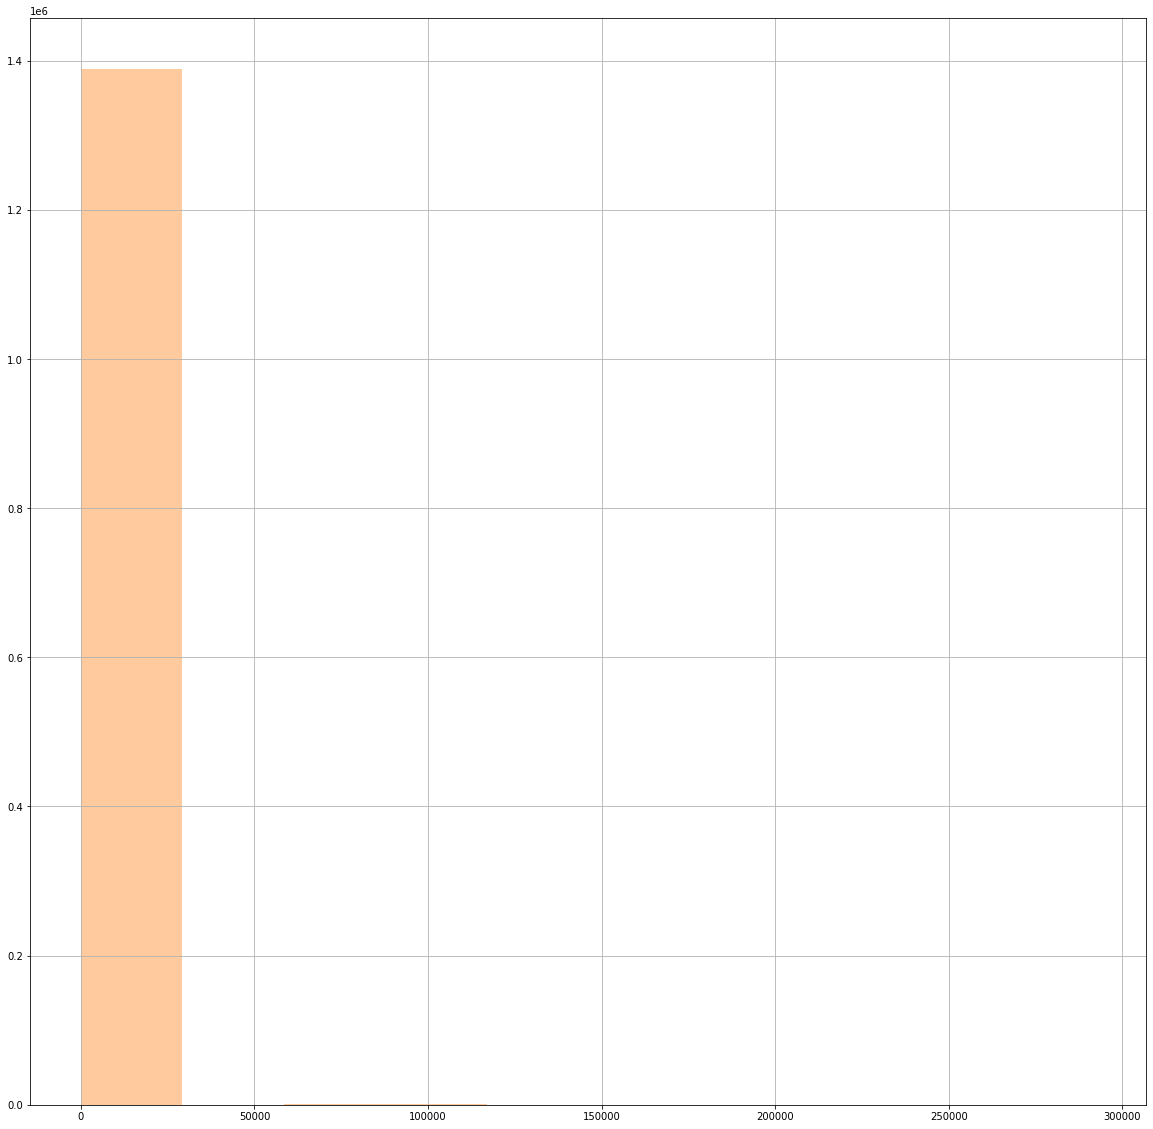

In [53]:
# Deal with inf and NaN values
df_cic_ids_hist.fillna(0)
df_cic_ids_hist.replace(np.inf, 9999, inplace=True)
df_cic_ids_hist.groupby("Label").IN_PKTS.hist(alpha=0.4, figsize=(20,20))

In [54]:
del df_cic_ids_hist
gc.collect()

0

BoT-IoT

In [55]:
df_bot_iot_hist = df_bot_iot_top.loc[:, ~df_bot_iot_top.columns.isin(remove_columns)].copy()
df_bot_iot_hist.describe()

,Unnamed: 0,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,MAX_TTL,LONGEST_FLOW_PKT,SHORTEST_FLOW_PKT,MIN_IP_PKT_LEN,MAX_IP_PKT_LEN,SRC_TO_DST_SECOND_BYTES,DST_TO_SRC_SECOND_BYTES,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,NUM_PKTS_UP_TO_128_BYTES,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label
count,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,1.846084e+07,18460837.0,1.846084e+07,1.846084e+07
mean,1.888024e+07,6.573539e+02,3.079615e+00,1.927917e+02,2.103608e-01,1.863247e-01,1.042967e-01,9.123503e-02,4.210067e+06,9.003103e+02,5.453855e+00,6.247866e+01,6.247866e+01,2.952830e+01,2.863366e+01,3.594766e-01,2.952830e+01,9.250922e+16,3.060307e+20,1.501440e+01,5.400974e-02,1.136206e-01,8.067890e-04,1.959753e+05,7.662000e+03,2.406107e+00,2.317121e-02,1.210181e-01,4.048112e-01,3.348670e-01,1.194970e+02,6.539838e+00,5.011321e+01,1.957540e-01,4.668543e+00,1.678147e-03,0.0,6.939014e-05,9.930128e-01
std,1.090323e+07,1.106336e+05,1.246455e+02,6.386367e+04,6.556142e+01,1.978536e+00,1.308718e+00,1.232004e+00,5.945984e+05,3.592099e+02,1.019136e+02,9.941922e+00,9.941922e+00,2.851803e+01,9.618228e+00,5.717058e+00,2.851803e+01,9.628884e+19,9.281679e+23,5.828353e+03,2.066795e+01,5.115077e+00,2.950775e-02,3.400102e+06,1.945801e+06,3.454004e+01,3.262372e+00,2.495158e+01,8.178736e+01,6.956598e+01,1.828031e+03,3.727591e+02,1.340076e+03,5.234652e+00,4.531757e+02,1.419221e-01,0.0,1.818726e-01,8.329708e-02
min,3.000000e+00,2.800000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.800000e+01,2.800000e+01,0.000000e+00,2.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
25%,9.435035e+06,5.600000e+01,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.293763e+06,6.400000e+02,0.000000e+00,6.400000e+01,6.400000e+01,2.800000e+01,2.800000e+01,0.000000e+00,2.800000e+01,2.828000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.240000e+05,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,1.000000e+00
50%,1.887976e+07,5.600000e+01,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.294014e+06,9.320000e+02,0.000000e+00,6.400000e+01,6.400000e+01,2.800000e+01,2.800000e+01,0.000000e+00,2.800000e+01,2.828000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.240000e+05,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,1.000000e+00
75%,2.832544e+07,5.600000e+01,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.294296e+06,1.187000e+03,0.000000e+00,6.400000e+01,6.400000e+01,2.800000e+01,2.800000e+01,0.000000e+00,2.800000e+01,2.828000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,

Label
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: IN_PKTS, dtype: object

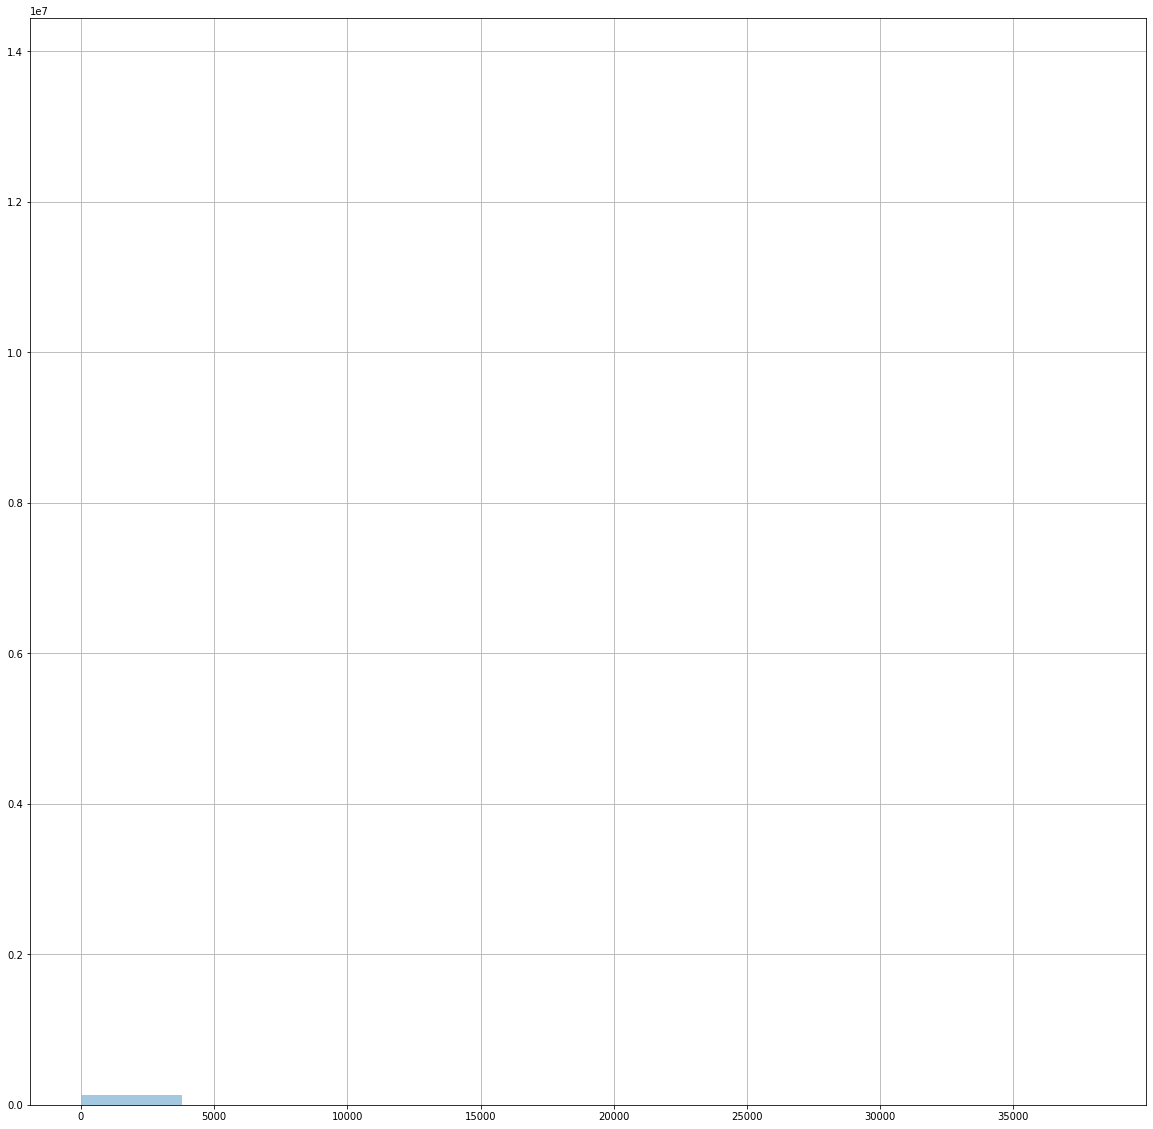

In [56]:
# Deal with inf and NaN
df_bot_iot_hist.fillna(0)
df_bot_iot_hist.replace(np.inf, 9999, inplace=True)
df_bot_iot_hist.groupby("Label").IN_PKTS.hist(alpha=0.4, figsize=(20,20))

In [57]:
del df_bot_iot_hist
gc.collect()

0

## Check for linear correlation between features for dataset with DDoS and Benign Flows

### DDoS Samples

### Benign Samples

In [58]:
# Checks if devices have received data from multiple sources to not bias models
for agent in feasible_agents:
    print("Agent:\t", agent, end='\t')
    sources = df_ton_iot_top[df_ton_iot_top.IPV4_DST_ADDR == agent]['IPV4_SRC_ADDR'].unique()
    print("Sources Count:\t", len(sources))

Agent:	 192.168.1.184	Sources Count:	 3091
Agent:	 192.168.1.180	Sources Count:	 35
Agent:	 192.168.1.194	Sources Count:	 9098
Agent:	 192.168.1.195	Sources Count:	 90
Agent:	 192.168.1.190	Sources Count:	 5573
Agent:	 192.168.1.152	Sources Count:	 5090
Agent:	 192.168.1.193	Sources Count:	 47
Agent:	 192.168.1.1	Sources Count:	 17
Agent:	 176.28.50.165	Sources Count:	 7


In [59]:
# Checks if devices have received data from multiple sources to not bias models
for device in top_cic_ids:
    print("Device:\t", device, end='\t')
    sources = df_cic_ids_top[df_cic_ids_top.IPV4_DST_ADDR == device]['IPV4_SRC_ADDR'].unique()
    print("Sources Count:\t", len(sources))

Device:	 172.31.69.28	Sources Count:	 1622
Device:	 172.31.69.25	Sources Count:	 929


In [60]:
# Checks if devices have received data from multiple sources to not bias models
for device in top_bot_iot:
    print("Device:\t", device, end='\t')
    sources = df_bot_iot_top[df_bot_iot_top.IPV4_DST_ADDR == device]['IPV4_SRC_ADDR'].unique()
    print("Sources Count:\t", len(sources))

Device:	 192.168.100.3	Sources Count:	 14
Device:	 192.168.100.5	Sources Count:	 5
Device:	 192.168.100.7	Sources Count:	 4
Device:	 192.168.100.6	Sources Count:	 5
Device:	 192.168.100.148	Sources Count:	 4
Device:	 192.168.100.149	Sources Count:	 4
Device:	 192.168.100.150	Sources Count:	 4
Device:	 192.168.100.147	Sources Count:	 4
Device:	 192.168.159.152	Sources Count:	 1


---
# Data split

> **Premises**:
> - All agents share the same feature set
> - Each agent has access only to network traffic that are target to him
>
> HFL is applicable based on this premises. However, the share of common feature sets is a challenge that must be agreed up-front
>
> **Horizontally partitioned federated learning (HFL):** data distributed in different silos contain the _same feature space_ and _different samples_$^1$.
>
> $^1$ https://blog.openmined.org/federated-learning-types/

### Attention point for Non-IID
> Non-independently and identically distributed data, data across agents are not identically distributed

- Distribution skew between Agents (unbalance dataset)
- Quantity skew between Agents (number of samples)

In [61]:
df_ton_iot_top['IPV4_DST_ADDR'].unique()

array(['192.168.1.152', '192.168.1.193', '192.168.1.190', '192.168.1.1',
       '192.168.1.180', '192.168.1.194', '192.168.1.195', '192.168.1.184',
       '176.28.50.165'], dtype=object)

In [62]:
df_cic_ids_top['IPV4_DST_ADDR'].unique()

array(['172.31.69.25', '172.31.69.28'], dtype=object)

In [63]:
df_bot_iot_top['IPV4_DST_ADDR'].unique()

array(['192.168.100.7', '192.168.100.6', '192.168.100.3', '192.168.100.5',
       '192.168.100.148', '192.168.100.149', '192.168.100.147',
       '192.168.100.150', '192.168.159.152'], dtype=object)

# Silos creation

In [64]:
remove_columns = ['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO']

ToN-IoT Silos Creation

In [65]:
agent_ton_iot = list() 

for device in feasible_agents:
    agent_ton_iot.append(
        df_ton_iot_top[df_ton_iot_top.IPV4_DST_ADDR == device]
            .copy()
            .drop(remove_columns, axis=1)
            .reset_index(drop=True)
    )

In [66]:
agent_ton_iot[0].head()

,Unnamed: 0,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,MAX_TTL,LONGEST_FLOW_PKT,SHORTEST_FLOW_PKT,MIN_IP_PKT_LEN,MAX_IP_PKT_LEN,SRC_TO_DST_SECOND_BYTES,DST_TO_SRC_SECOND_BYTES,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,NUM_PKTS_UP_TO_128_BYTES,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label
0,5717165,44,1,40,1,22,2,20,0,0,0,0,0,44,40,40,44,44.0,40.0,0,0,0,0,352000,320000,2,0,0,0,0,1024,0,0,0,0,0,0,0,0
1,5717175,44,1,40,1,22,2,20,0,0,0,0,0,44,40,40,44,44.0,40.0,0,0,0,0,352000,320000,2,0,0,0,0,1024,0,0,0,0,0,0,0,0
2,5717178,44,1,40,1,22,2,20,0,0,0,0,0,44,40,40,44,44.0,40.0,0,0,0,0,352000,320000,2,0,0,0,0,1024,0,0,0,0,0,0,0,0
3,5717184,44,1,40,1,22,2,20,0,0,0,0,0,44,40,40,44,44.0,40.0,0,0,0,0,352000,320000,2,0,0,0,0,1024,0,0,0,0,0,0,0,0
4,5717197,44,1,40,1,22,2,20,0,0,0,0,0,44,40,40,44,44.0,40.0,0,0,0,0,352000,320000,2,0,0,0,0,1024,0,0,0,0,0,0,0,0


In [67]:
agent_ton_iot_balance = list() 

for agent in agent_ton_iot: 
    agent_ton_iot_balance.append(agent['Label'].value_counts().to_dict())

In [68]:
for agent_balance in agent_ton_iot_balance:
    print(agent_balance)

{1: 1485720, 0: 64909}
{0: 721573, 1: 208}
{1: 305973, 0: 296947}
{0: 620719, 1: 5187}
{0: 623891, 1: 91243}
{0: 282044, 1: 95333}
{0: 336907, 1: 242}
{0: 63982, 1: 38160}
{1: 2838, 0: 1424}


In [69]:
del df_ton_iot_top
gc.collect()

0

CIC-IDS Silos Creation

In [70]:
agent_cic_ids = list() 

for device in top_cic_ids:
    agent_cic_ids.append(
        df_cic_ids_top[df_cic_ids_top.IPV4_DST_ADDR == device]
            .copy()
            .drop(remove_columns, axis=1)
            .reset_index(drop=True)
    )

In [71]:
agent_cic_ids_balance = list() 

for agent in agent_cic_ids: 
    agent_cic_ids_balance.append(agent['Label'].value_counts().to_dict())

In [72]:
for agent_balance in agent_cic_ids_balance:
    print(agent_balance)

{1: 1082970, 0: 4756}
{1: 307300, 0: 1333}


In [73]:
agent_cic_ids[0].head()

,Unnamed: 0,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,MAX_TTL,LONGEST_FLOW_PKT,SHORTEST_FLOW_PKT,MIN_IP_PKT_LEN,MAX_IP_PKT_LEN,SRC_TO_DST_SECOND_BYTES,DST_TO_SRC_SECOND_BYTES,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,NUM_PKTS_UP_TO_128_BYTES,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label
0,8,522,5,1147,5,219,219,27,4294963,3,3,127,127,975,40,40,975,522.0,1147.0,0,0,0,0,1040000,2288000,8,0,1,1,0,65535,26883,0,0,0,0,0,0,1
1,65,526,5,1147,5,219,219,27,4294925,41,41,127,127,975,40,40,975,526.0,1147.0,0,0,0,0,96000,216000,8,0,1,1,0,65535,26883,0,0,0,0,0,0,1
2,67,521,5,1147,5,219,219,27,4294768,198,198,127,127,975,40,40,975,521.0,1147.0,0,0,0,0,16000,40000,8,0,1,1,0,65535,26883,0,0,0,0,0,0,1
3,98,499,5,1147,5,219,219,27,4294936,30,30,127,127,975,40,40,975,499.0,1147.0,0,0,0,0,128000,296000,8,0,1,1,0,65535,26883,0,0,0,0,0,0,1
4,99,479,5,1147,5,219,219,27,4294956,10,10,127,127,975,40,40,975,479.0,1147.0,0,0,0,0,344000,832000,8,0,1,1,0,65535,26883,0,0,0,0,0,0,1


In [74]:
agent_cic_ids[1].head()

,Unnamed: 0,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,MAX_TTL,LONGEST_FLOW_PKT,SHORTEST_FLOW_PKT,MIN_IP_PKT_LEN,MAX_IP_PKT_LEN,SRC_TO_DST_SECOND_BYTES,DST_TO_SRC_SECOND_BYTES,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,NUM_PKTS_UP_TO_128_BYTES,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label
0,4,232,5,1136,4,223,222,27,4294827,140,0,127,127,1004,40,40,1004,2.320000e+02,1136.0,0,0,0,0,8000,9088000,8,0,0,1,0,8192,26883,0,0,0,0,0,0,1
1,41,407880,6798,0,0,0,0,0,4294686,281,0,127,127,60,60,0,60,1.689602e+11,0.0,0,0,0,0,12944000,0,6798,0,0,0,0,0,0,0,0,0,0,0,0,1
2,110,232,5,1136,4,223,222,27,4294951,16,0,127,127,1004,40,40,1004,2.320000e+02,1136.0,0,0,0,0,104000,9088000,8,0,0,1,0,8192,26883,0,0,0,0,0,0,1
3,124,232,5,1136,4,223,222,27,4294951,16,0,127,127,1004,40,40,1004,2.320000e+02,1136.0,0,0,0,0,104000,9088000,8,0,0,1,0,8192,26883,0,0,0,0,0,0,1
4,139,232,5,1136,4,223,222,27,4294905,62,0,127,127,1004,40,40,1004,1.924000e+04,1136.0,0,0,0,0,1536000,9088000,8,0,0,1,0,8192,26883,0,0,0,0,0,0,1


In [75]:
# Verifying the balance of each data silo
agent_cic_ids_balance = list() 

for agent in agent_cic_ids: 
    agent_cic_ids_balance.append(agent['Label'].value_counts().to_dict())

In [76]:
for agent_balance in agent_cic_ids_balance:
    print(agent_balance)

{1: 1082970, 0: 4756}
{1: 307300, 0: 1333}


In [77]:
del df_cic_ids_top
gc.collect()

0

BoT-IoT Silos Creation

In [78]:
agent_bot_iot = list() 

for device in top_bot_iot:
    agent_bot_iot.append(
        df_bot_iot_top[df_bot_iot_top.IPV4_DST_ADDR == device]
            .copy()
            .drop(remove_columns, axis=1)
            .reset_index(drop=True)
    )

In [79]:
agent_bot_iot_balance = list() 

for agent in agent_bot_iot: 
    agent_bot_iot_balance.append(agent['Label'].value_counts().to_dict())

In [80]:
for agent_balance in agent_bot_iot_balance:
    print(agent_balance)

{1: 8815480, 0: 31111}
{1: 4308860, 0: 3697}
{1: 2831589, 0: 3857}
{1: 2371793, 0: 3188}
{0: 23712, 1: 1028}
{0: 21063, 1: 1087}
{0: 20521, 1: 940}
{0: 19262, 1: 1070}
{0: 2579}


In [81]:
del df_bot_iot_top

In [82]:
gc.collect()

0

In [83]:
%whos DataFrame

Variable   Type         Data/Info
---------------------------------
agent      DataFrame          Unnamed: 0  IN_BYTE<...>n[2579 rows x 39 columns]


---
# Training generic LR model for each agent and compare the trained model against the other agents

In [84]:
def preprocess(X):
    cols = X.select_dtypes(include=[np.float64]).columns
    X[cols] = X[cols].astype(np.float32)

    X.fillna(0, inplace=True)
    X.replace(np.inf, 9999, inplace=True)
    
    return X

# Localized performance

In [85]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import balanced_accuracy_score, make_scorer, f1_score, roc_auc_score, precision_score, recall_score, roc_curve

## Localized model training

In [162]:
seed=42

# Agents created with ToN-IoT, CIC-IDS and BOT-IoT datasets
agents = {
    "agent1" : agent_ton_iot[0], 
    "agent2" : agent_ton_iot[1], 
    "agent3" : agent_ton_iot[2], 
    "agent4" : agent_ton_iot[3], 
    "agent5" : agent_ton_iot[4], 
    "agent6" : agent_ton_iot[5], 
    "agent7" : agent_ton_iot[6], 
    "agent8" : agent_ton_iot[7], 
    "agent9" : agent_ton_iot[8],
    "agent10" : agent_cic_ids[0],
    "agent11" : agent_cic_ids[1], 
    "agent12" : agent_bot_iot[0],
    "agent13" : agent_bot_iot[1], 
    "agent14" : agent_bot_iot[2], 
    "agent15" : agent_bot_iot[3], 
    "agent16" : agent_bot_iot[4], 
    "agent17" : agent_bot_iot[5], 
    "agent18" : agent_bot_iot[6], 
    "agent19" : agent_bot_iot[7], 
}

In [174]:
for name, agent in agents.items():
    agent_count = agent["Label"].count()
    label_count = agent["Label"].value_counts().to_dict()
    print(f"{name};{agent_count};{label_count[0]/agent_count};{label_count[1]/agent_count}")

agent1;1550629;0.041859787221830626;0.9581402127781694
agent2;721781;0.9997118239465987;0.00028817605340123944
agent3;602920;0.4925147614940622;0.5074852385059377
agent4;625906;0.9917128131061214;0.008287186893878633
agent5;715134;0.872411324311248;0.12758867568875204
agent6;377377;0.7473799410138933;0.25262005898610673
agent7;337149;0.9992822164680898;0.0007177835319102237
agent8;102142;0.626402459321337;0.373597540678663
agent9;4262;0.334115438761145;0.665884561238855
agent10;1087726;0.004372424673125401;0.9956275753268746
agent11;308633;0.004319045597845985;0.995680954402154
agent12;8846591;0.003516721864953404;0.9964832781350466
agent13;4312557;0.0008572640315246848;0.9991427359684754
agent14;2835446;0.0013602798289933929;0.9986397201710067
agent15;2374981;0.0013423265280859088;0.9986576734719141
agent16;24740;0.9584478577202911;0.04155214227970897
agent17;22150;0.9509255079006772;0.0490744920993228
agent18;21461;0.9561996179115605;0.0438003820884395
agent19;20332;0.947373598268738

In [87]:
results = {}
cross_validation_test = True 

for name, agent in agents.items():
    X = agent.drop(columns = ["Label"])
    y = agent.Label

    X = preprocess(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y) #stratified

    clf = SGDClassifier(random_state=seed, loss="log", class_weight="balanced")
    parameters = {}
    
    prep = StandardScaler() 
    X_train = prep.fit_transform(X_train)
    clf.fit(X_train, y_train)
    
    X_test = prep.transform(X_test) 
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:,1] # for ROC curve, get just for positive class "1"
    
    score = f1_score(y_test, y_pred, average="binary") # binary only report results for the class 1 (pos_label)
    
    print(name, set(y_test), set(y_pred), "{:.2f}".format(score))
    
    if(cross_validation_test):
        results[name] = {}
        results[name][name] = score
        results[name]["accuracy"] = balanced_accuracy_score(y_test, y_pred)
        results[name]["precision"] = precision_score(y_test, y_pred, average="binary")
        results[name]["recall"] =  recall_score(y_test, y_pred, average="binary")
        results[name]["auc"] = roc_auc_score(y_test, y_pred)
        results[name]["fpr"], results[name]["tpr"], results[name]["thresholds"] = roc_curve(y_test, y_proba)
        results[name]["%benign"] = float("{:.3f}".format(sum(y==0)/len(y)))
        results[name]["%ddos"] = float("{:.3f}".format(sum(y==1)/len(y)))
        results[name]["total_samples"] = len(y)
        # parameters from LR model to be used on FedAvg
        results[name]["coef"] = clf.coef_
        results[name]["intercept"] = clf.intercept_
        results[name]["classes"] = clf.classes_
        results[name]["n_iter"] = clf.n_iter_
    
        # Evaluate final model against other agents (datasets)
        for test_name, test_agent in agents.items():
            if test_name == name:
                continue
            X = test_agent.drop(columns = ["Label"])
            y = test_agent.Label
            X = preprocess(X)
            X = prep.transform(X)
            results[name][test_name] = f1_score(y, clf.predict(X), average="binary")

agent1 {0, 1} {0, 1} 1.00
agent2 {0, 1} {0, 1} 0.95
agent3 {0, 1} {0, 1} 0.99
agent4 {0, 1} {0, 1} 0.86
agent5 {0, 1} {0, 1} 0.98
agent6 {0, 1} {0, 1} 0.99
agent7 {0, 1} {0, 1} 0.23
agent8 {0, 1} {0, 1} 0.74
agent9 {0, 1} {0, 1} 0.99
agent10 {0, 1} {0, 1} 1.00
agent11 {0, 1} {0, 1} 1.00
agent12 {0, 1} {0, 1} 0.99
agent13 {0, 1} {0, 1} 1.00
agent14 {0, 1} {0, 1} 0.99
agent15 {0, 1} {0, 1} 0.99
agent16 {0, 1} {0, 1} 0.17
agent17 {0, 1} {0, 1} 0.16
agent18 {0, 1} {0, 1} 0.14
agent19 {0, 1} {0, 1} 0.16


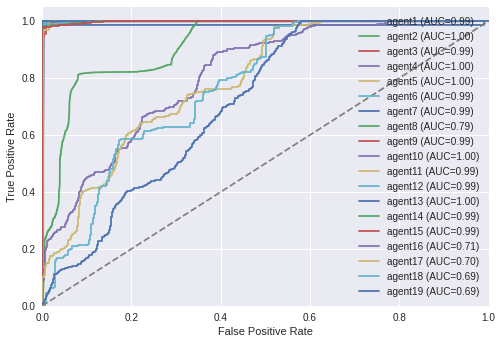

In [88]:
plt.style.use('seaborn')
plt.figure()

index = 0
for model_key, result in results.items():
    fpr, tpr, thresholds = result["fpr"], result["tpr"], result["thresholds"]
    AUC = result["auc"]
    
    plt.plot(fpr, tpr, label="{} (AUC={:.2f})".format(model_key, AUC))
    index = index + 1
    
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

In [89]:
def process_results(results, remove_list=[]):
    all_values = []
    for major_key in results.keys():
        if (major_key in remove_list) in remove_list:
            continue
        values = []
        for key in agents.keys():
            if key in remove_list:
                continue
            values.append(results[major_key][key])
        all_values.append(values)
    return all_values

In [90]:
remove_list = []
localized_results = process_results(results, remove_list)

## Cross-agents performance
> Trained in one silo and evaluated in the others

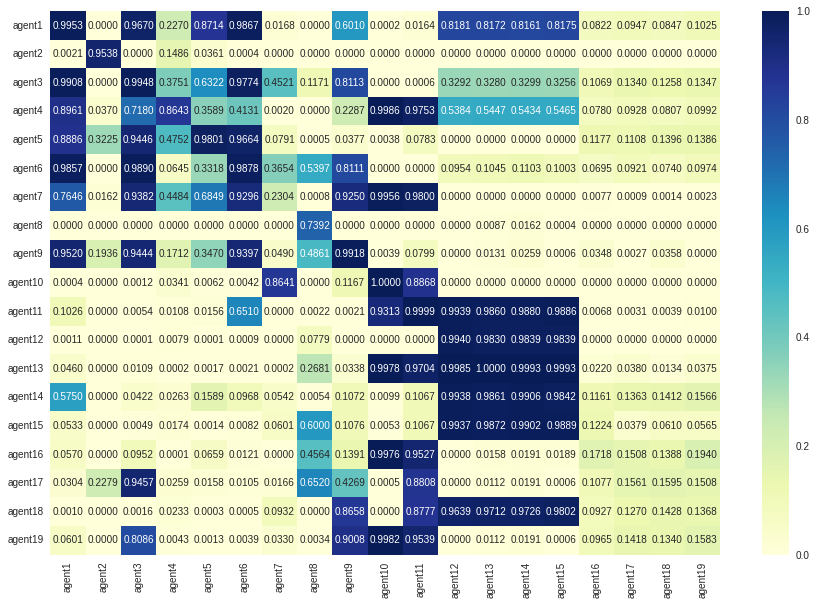

In [91]:
labels = [i for i in agents.keys() if i not in remove_list]
plt.figure(figsize = (15,10))
ax = sns.heatmap(localized_results, vmin=0, vmax=1, annot=True, fmt=".4f", xticklabels=labels, yticklabels=labels, cmap="YlGnBu")

In [92]:
# Python program to get average of a list
def average(lst):
    return sum(lst) / len(lst)

In [93]:
# Calculation of the average of the model of each of the agents evaluated in other datasets
average_f1_score = dict()
for i, name in enumerate(agents.keys()):
    average_f1_score[name] = average(localized_results[i])

for value in average_f1_score.values():
    print(value)

0.4376202962388533
0.06005307080972326
0.3771365740972173
0.4218857343650787
0.2780843106788519
0.3062375425252598
0.36453306931758644
0.04023597256668516
0.27744473464472863
0.15335465053577396
0.35269058557981636
0.21224663540425848
0.33891514785546456
0.2993406603674737
0.2738168223793996
0.18343671394687971
0.20199238172253986
0.32898157624965174
0.2278374003218769


---
# Federated Learning (Federated Averaging - _FedAvg_)
---

## Horizontal Federated Learning

Network traffic analysis for the identification of malicious objects.
The work aims to identify malicious packages. The analysis will be performed on a dataset composed of extracts of network traffic, with objects labeled as legitimate or malicious. Training of supervised classification algorithms will be performed to identify malicious examples.

Horizontal approach in which multiple datasets share the same feature set, but with data packages independent of each other. The aim of the work is to use data from independent agents to evaluate how a model trained on a dataset performs being evaluated with an independent dataset.

In addition, the work seeks to evaluate how the generated models behave with a data set without any contact with the training process, for which the agents will be divided into a training set, a test set and finally a data set. of validation. Also, an analysis is carried out on the importance of the features present in the datasets, for this an exhaustive analysis was carried out, eliminating combinations of features and performing an analysis of the f1-score behavior of the models.

The pre-training silos are balanced to match the number of malicious and benign data. Due to the amount of data in some of the silos being relatively limited, we chose to reserve 10% of the dataset for the validation phase.

---------------

#### Generation of validation data

In [94]:
validation_agents = dict()
DIVCOEF = 10
seed = 42

for agent_name, agent_data in agents.items():
    X = agent_data
    y = agent_data["Label"]
    train_test_data, validation_data, _, _ = train_test_split(X, y, test_size=1/DIVCOEF, random_state=seed, stratify=y)
    agents[agent_name] = train_test_data 
    validation_agents[agent_name] = validation_data

### Global Model

In [230]:
fedavg = SGDClassifier() 

def initialize_global_model(agent, features_to_drop):
    lr = 0.1
    fedavg = SGDClassifier(n_jobs=-1, random_state=seed, loss="log", learning_rate='constant', eta0=lr, verbose=0) # global
    features = agent.drop(columns=features_to_drop).shape[1] # total number of features
    fedavg.intercept_ = np.zeros(1)
    fedavg.coef_ = np.zeros((1, features))
    fedavg.classes_ = np.array([0, 1])
    return fedavg

### Agent Models

In [96]:
sgd_agents = dict()
for agent in agents.keys():
    sgd_agents[agent] = SGDClassifier(n_jobs=-1, random_state=seed, loss="log", learning_rate='constant', eta0=lr, verbose=0)

### Auxiliary Functions

In [97]:
# update each agent model by current global model values
def load_global_model(model):
    model.intercept_ = fedavg.intercept_.copy()
    model.coef_ = fedavg.coef_.copy()
    return model

In [98]:
def update_global_model(applicable_models, round_weights):
    # Average models parameters
    coefs = []
    intercept = []
    for model in applicable_models:
        coefs.append(model.coef_)
        intercept.append(model.intercept_)
    
    # average and update FedAvg (aggregator model)
    fedavg.coef_ = np.average(coefs, axis=0, weights=round_weights) # weight
    fedavg.intercept_ = np.average(intercept, axis=0, weights=round_weights) # weight

In [99]:
def train_local_agent(X, y, model, epochs, class_weight):
    for _ in range(0, epochs):
        model.partial_fit(X, y, classes=np.unique(y), sample_weight=class_weight)
    return model

In [100]:
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight

### FedAvg hyperparameters

In [101]:
rounds = 50

# Epochs
# FedAvg requires a minimum number of training epochs before averaging
# For epoch=1 is the same as FedSGD (https://www.cs.cornell.edu/~shmat/shmat_ccs15.pdf)
epochs = 20

# train_size same as batch size
# If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the train split. 
# If int, represents the absolute number of train samples
train_size=100 #0.05

# remove_agents = ["agent8", "agent21",  "agent2", "agent5", "agent24", "agent25", "agent26", "agent27"]
remove_agents = []

The number of agents participating in each round is random.

### FedAvg Main Loop

In [102]:
# Flag that enables balancing between attack classes and benign databalanced = True 
def rebalance_agent(agent):
    agent_label_count = agent["Label"].value_counts().to_dict()
    benign_count = agent_label_count[0] 
    malicious_count = agent_label_count[1]
    
    if(balanced):
        if (benign_count > malicious_count):
            downsampled_0 = resample(
                                agent[agent.Label == 0], 
                                replace=False, 
                                n_samples=agent[agent.Label == 1].shape[0],
                                random_state=1337
                            )
            agent_balanced = pd.concat([downsampled_0, agent[agent.Label == 1]])
        elif (benign_count < malicious_count): 
            downsampled_1 = resample(
                                agent[agent.Label == 1], 
                                replace=False, 
                                n_samples=agent[agent.Label == 0].shape[0], 
                                random_state=1337
                            )
            agent_balanced = pd.concat([downsampled_1, agent[agent.Label == 0]])
        else:
            agent_balanced = agent
    else:
        agent_balanced = agent
    
    return agent_balanced

In [103]:
def test_agent_model(clf, agent):
    X = agent.drop(columns = ["Label"])
    y = agent.Label
    X = preprocess(X)
    
    X_train, X_test, _, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y) #stratified
    
    prep = StandardScaler() 
    
    X_train = prep.fit_transform(X_train)
    X_test = prep.transform(X_test) 
    y_pred = clf.predict(X_test)
    
    return f1_score(y_test, y_pred, average="binary")

In [104]:
rounds_f1_score = dict() 

print("Federated Learning Started.")
for r in range(rounds):
    # The number of devices participating in federated training will be a random number from the devices 
    # in the agent list
    sample_size = random.randint(int(len(agents)/2), len(agents))
    applicable_agents = random.sample(list(agents.keys()), k=sample_size) # select random agents/silos

    applicable_models = []
    applicable_name = []

    # for calculating weighted average
    round_weights = []
    dataset_size = 0

    for name, agent in agents.items():
        if name not in applicable_agents: # check if agent/silos is in applicable_agents
            continue

        if name in remove_agents: # check if agent/silos is in remove_agents, if yes, jump (refer to FedAvg hyperparams)
            continue
        
        applicable_name.append(name)

        # Rebalance datasets to improve performance
        agent_balanced = rebalance_agent(agent)
        
        print(".", end=" ")
        X = agent_balanced.drop(columns = ["Label"])
        y = agent_balanced.Label
      
        X = preprocess(X)

        X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=train_size, stratify=y) #stratified / random_state=seed
        X_train = prep.fit_transform(X_train)

        dataset_size += X_train.shape[0]

        sample_weights = compute_sample_weight('balanced', y=y_train)
        sgd_agents[name] = load_global_model(sgd_agents[name])
        sgd_agents[name] = train_local_agent(X_train, y_train, sgd_agents[name], epochs, sample_weights)
        round_weights.append(X_train.shape[0])
        applicable_models.append(sgd_agents[name])

    # Update global model (FedAvg) after each round
    round_weights = np.array(round_weights) / dataset_size # calculate weight based on actual dataset size

    try:
        update_global_model(applicable_models, round_weights)
    except:
        print("Error updating global model")
    
     # Sends trained model to agents and evaluates f1-score per round
    for name, agent in agents.items():
        sgd_agents[name] = load_global_model(sgd_agents[name])
        """if(not name in rounds_f1_score):
            rounds_f1_score[name] = list()
        rounds_f1_score[name].append(test_agent_model(fedavg, agent))"""

Treinamento Federado Iniciado.
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

Display of the evolution of the F1-Score training metric by rounds

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


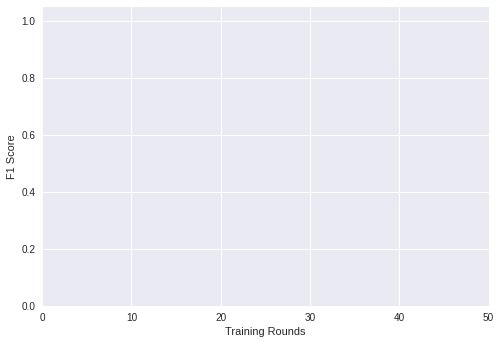

In [105]:
index = 0 
plt.style.use('seaborn')
plt.figure()

for name, metric in rounds_f1_score.items():
    rounds_list = [i for i in range(len(metric))]
    plt.plot(rounds_list, metric, label="{}".format(name))
    index = index + 1
    
plt.xlim([0.0, 50.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Training Rounds')
plt.ylabel('F1 Score')
plt.legend(loc="lower right")

Evolution of the learning metric of the models according to the rounds

In [1]:
################################################################
### average
for name, agent in agents.items():

    if name in remove_agents:
            continue

    score_fedavg = []
    score_local = []

    # Rebalance datasets to improve performance
    agent_balanced = rebalance_agent(agent)
    
    X = agent_balanced.drop(columns = ["Label"])
    y = agent_balanced.Label
    
    X = preprocess(X)
   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y) #stratified

    X_train = prep.fit_transform(X_train)    
    X_test = prep.transform(X_test) 

    y_pred = fedavg.predict(X_test)
    score_fedavg.append(f1_score(y_test, y_pred, average="binary")) # binary only report results for the class 1 (pos_label)
    
    y_pred = sgd_agents[name].predict(X_test)
    score_local.append(f1_score(y_test, y_pred, average="binary"))

print("Federated Learning Finished.")
score_fedavg, score_local

NameError: name 'agents' is not defined

# Plots

/home/leohmelo/venv/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/leohmelo/venv/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/leohmelo/venv/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/leohmelo/venv/lib/python3.10/site-packages/

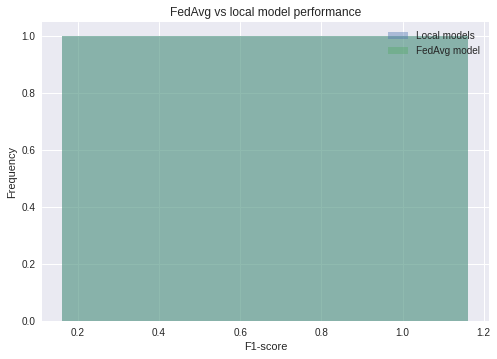

In [107]:
fig, ax = plt.subplots()
ax.set(xlabel='F1-score', ylabel='Frequency')
ax.set_title('FedAvg vs local model performance')
sns.distplot(score_local, ax=ax, kde=True, label="Local models")
sns.distplot(score_fedavg, ax=ax, kde=True, label="FedAvg model")
ax.legend()

In [110]:
# Checks if the global learning model is the same as the localized models
results_fedavg = {}

for name, agent in agents.items():
    
    if name in remove_agents:
            continue
            
    score = []
    score_local = 0
    
    # agent_balanced = rebalance_agent(agent) 
    
    #X = agent_balanced.drop(columns = ["Label"])
    #y = agent_balanced.Label
    
    X = agent.drop(columns=["Label"])
    y = agent.Label
    X = preprocess(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y) #stratified

    X_train = prep.fit_transform(X_train)    
    X_test = prep.transform(X_test) 
    
    y_pred = fedavg.predict(X_test)
    score.append(f1_score(y_test, y_pred, average="binary")) # binary only report results for the class 1 (pos_label)
    
    y_pred = sgd_agents[name].predict(X_test)
    score.append(f1_score(y_test, y_pred, average="binary"))

    results_fedavg[name] = score

In [111]:
results_fedavg

{'agent1': [0.8402360023525093, 0.8402360023525093],
 'agent2': [0.014327747217602658, 0.014327747217602658],
 'agent3': [0.9808687339427615, 0.9808687339427615],
 'agent4': [0.1622759533261157, 0.1622759533261157],
 'agent5': [0.6951373248912874, 0.6951373248912874],
 'agent6': [0.9490710786579166, 0.9490710786579166],
 'agent7': [0.004742848673484512, 0.004742848673484512],
 'agent8': [0.04824185248713551, 0.04824185248713551],
 'agent9': [0.8871758934828312, 0.8871758934828312],
 'agent10': [0.5725095624113631, 0.5725095624113631],
 'agent11': [0.8771135163639069, 0.8771135163639069],
 'agent12': [0.4571694913277872, 0.4571694913277872],
 'agent13': [0.415639635617777, 0.415639635617777],
 'agent14': [0.4400751222368554, 0.4400751222368554],
 'agent15': [0.4662350850469662, 0.4662350850469662],
 'agent16': [0.13025780189959296, 0.13025780189959296],
 'agent17': [0.11104256631708821, 0.11104256631708821],
 'agent18': [0.134936539746159, 0.134936539746159],
 'agent19': [0.162425932380

---
### Analysis evaluating data from one silo to others.
---

In [112]:
cross_validation_results = dict()

print("Cross Validation Analisys Started...")
for name, agent in agents.items():
    
    print(".", end="")
    if name in remove_agents:
            continue
            
    agent_balanced = rebalance_agent(agent) 
    
    X = agent_balanced.drop(columns = ["Label"])
    y = agent_balanced.Label

    X = preprocess(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y) #stratified
    
    X_train = prep.fit_transform(X_train)
    X_test = prep.transform(X_test) 
    
    y_pred = sgd_agents[name].predict(X_test)
    
    cross_validation_results[name] = dict()
    cross_validation_results[name][name] = f1_score(y_test, y_pred, average="binary")
    
    print(name + " " + str(cross_validation_results[name][name]))
    
    for test_name, test_agent in agents.items():
        if test_name == name:
            continue
        
        X = test_agent.drop(columns = ["Label"])
        y = test_agent.Label
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y) #stratified
        X_test = preprocess(X_test)
        X_test = prep.transform(X_test)
        
        y_pred = sgd_agents[name].predict(X_test)
        cross_validation_results[name][test_name] = f1_score(y_test, y_pred, average="binary")

Cross Validation Analisys Started...
.agent1 0.9462777777777778
.agent2 0.9572649572649572
.agent3 0.9804809609373077
.agent4 0.9207519351271655
.agent5 0.857892637457225
.agent6 0.9840909528114962
.agent7 0.8870967741935484
.agent8 0.05878280571464536
.agent9 0.8683181225554106
.agent10 0.971580143993937
.agent11 0.8758716875871687
.agent12 0.8036617682486148
.agent13 0.012330456226880393
.agent14 0.9183303085299456
.agent15 0.9771528998242531
.agent16 0.6467289719626169
.agent17 0.6505636070853462
.agent18 0.65439672801636
.agent19 0.6621621621621621


In [113]:
under_sampling_results = process_results(cross_validation_results, remove_agents)

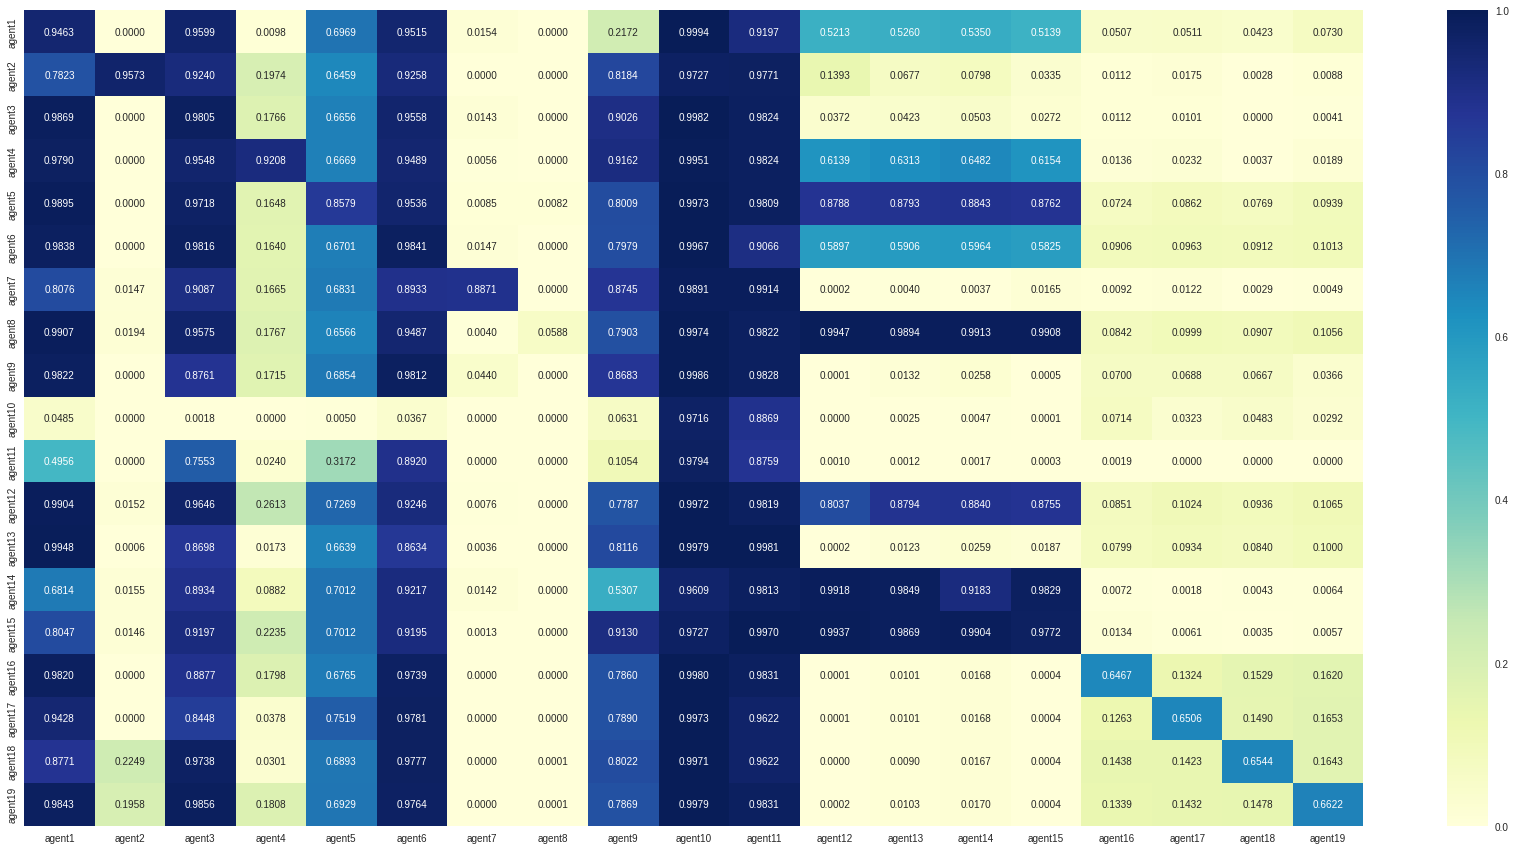

In [114]:
labels = [i for i in agents.keys() if i not in remove_agents]
plt.figure(figsize = (30,15))
ax = sns.heatmap(under_sampling_results, vmin=0, vmax=1, annot=True, fmt=".4f", xticklabels=labels, yticklabels=labels, cmap="YlGnBu")

In [115]:
# Calculation of the average of the model of each of the agents evaluated in other datasets
average_f1_score = dict()
for i, name in enumerate(agents.keys()):
    average_f1_score[name] = average(under_sampling_results[i])

for value in average_f1_score.values():
    print(value)

0.42258855573980014
0.39797407334184637
0.360283716457157
0.5230359470893917
0.5569214420039701
0.4862033448918372
0.3826066349155271
0.5752078802201357
0.36168109150187944
0.11589670212021456
0.23425089667669932
0.551515115407103
0.3492286967332802
0.5098028004817037
0.5496860201916282
0.39938456608032774
0.3906447414271483
0.40344350959496494
0.4157304385855669


### Data analysis performing balancing through Over Sampling

As some classes have little data in the class that represents malicious data, downsampling the information can cause the majority class to lose information. In this way, an approach to oversampling the majority class will be carried out.

In [146]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter

In [147]:
# oversample = RandomOverSampler(sampling_strategy='minority')
oversample = SMOTE(n_jobs=-1)

In [149]:
# Function to create balanced training data
X_smote = dict()
y_smote = dict() 

for name, agent in agents.items():
    
    X_imbalanced = agent.drop(columns = ["Label"])
    y_imbalanced = agent.Label
    X_imbalanced = preprocess(X_imbalanced)
    
    X, y = oversample.fit_resample(X_imbalanced, y_imbalanced)
    
    X_smote[name] = X
    y_smote[name] = y
    
    print(Counter(y))

Counter({0: 1337148, 1: 1337148})
Counter({0: 649415, 1: 649415})
Counter({1: 275376, 0: 275376})
Counter({0: 558647, 1: 558647})
Counter({0: 561501, 1: 561501})
Counter({1: 253839, 0: 253839})
Counter({0: 303216, 1: 303216})
Counter({0: 57583, 1: 57583})
Counter({1: 2554, 0: 2554})
Counter({1: 974673, 0: 974673})
Counter({1: 276569, 0: 276569})
Counter({1: 7933931, 0: 7933931})
Counter({1: 3877974, 0: 3877974})
Counter({1: 2548430, 0: 2548430})
Counter({1: 2134613, 0: 2134613})
Counter({0: 21341, 1: 21341})
Counter({0: 18957, 1: 18957})
Counter({0: 18468, 1: 18468})
Counter({0: 17335, 1: 17335})


In [2]:
# Conducting federated training with balanced data
print("Federated Learning Started.")
for r in range(rounds):
    # Conducting federated training with rebalanced data.
    sample_size = random.randint(int(len(agents)/2), len(agents))
    applicable_agents = random.sample(list(agents.keys()), k=sample_size) # select random agents/silos

    applicable_models = []
    applicable_name = []

    # for calculating weighted average
    round_weights = []
    dataset_size = 0

    for name, agent in agents.items():
        if name not in applicable_agents: # check if agent/silos is in applicable_agents
            continue

        if name in remove_agents: # check if agent/silos is in remove_agents, if yes, jump (refer to FedAvg hyperparams)
            continue
        
        applicable_name.append(name)
        
        print(".", end=" ")
        
        X = X_smote[name]
        y = y_smote[name]
        
        print(Counter(y))
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=train_size, stratify=y) #stratified / random_state=seed
        
        X_train = prep.fit_transform(X_train)

        dataset_size += X_train.shape[0]

        sample_weights = compute_sample_weight('balanced', y=y_train)
        sgd_agents[name] = load_global_model(sgd_agents[name])
        sgd_agents[name] = train_local_agent(X_train, y_train, sgd_agents[name], epochs, sample_weights)
        round_weights.append(X_train.shape[0])
        applicable_models.append(sgd_agents[name])

    # Update global model (FedAvg) after each round
    round_weights = np.array(round_weights) / dataset_size # calculate weight based on actual dataset size

    try:
        update_global_model(applicable_models, round_weights)
    except:
        print("Error to update global model")
        
    # Sends the trained model to the agents
    for name, agent in agents.items():
        sgd_agents[name] = load_global_model(sgd_agents[name])

Federated Learning Started.


NameError: name 'rounds' is not defined

In [157]:
cross_validation_over_samples = dict()

print("Cross Validation Analisys Started...")
for name, agent in agents.items():
    
    print(".", end="")
    if name in remove_agents:
            continue
        
    X_imbalanced = agent.drop(columns = ["Label"])
    y_imbalanced = agent.Label
    
    X = preprocess(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y) #stratified
    
    X_train = prep.fit_transform(X_train)
    X_test = prep.transform(X_test) 
    
    y_pred = sgd_agents[name].predict(X_test)
    
    cross_validation_over_samples[name] = dict()
    cross_validation_over_samples[name][name] = f1_score(y_test, y_pred, average="binary")
    
    print(name + " " + str(cross_validation_over_samples[name][name]))
    
    for test_name, test_agent in agents.items():
        if test_name == name:
            continue
        
        X = test_agent.drop(columns = ["Label"])
        y = test_agent.Label
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)
        
        X_test = preprocess(X_test)
        X_test = prep.transform(X_test)
        
        y_pred = sgd_agents[name].predict(X_test)
        cross_validation_over_samples[name][test_name] = f1_score(y_test, y_pred, average="binary")

Cross Validation Analisys Started...
.agent1 0.10400478182904961
.agent2 0.12250794568043917
.agent3 0.12250794568043917
.agent4 0.12250794568043917
.agent5 0.12250794568043917
.agent6 0.12250794568043917
.agent7 0.12250794568043917
.agent8 0.12250794568043917
.agent9 0.12250794568043917
.agent10 0.12250794568043917
.agent11 0.12250794568043917
.agent12 0.12250794568043917
.agent13 0.12250794568043917
.agent14 0.12250794568043917
.agent15 0.12250794568043917
.agent16 0.12250794568043917
.agent17 0.12250794568043917
.agent18 0.12250794568043917
.agent19 0.12250794568043917


In [175]:
over_sampling_results = process_results(cross_validation_over_samples, remove_agents)

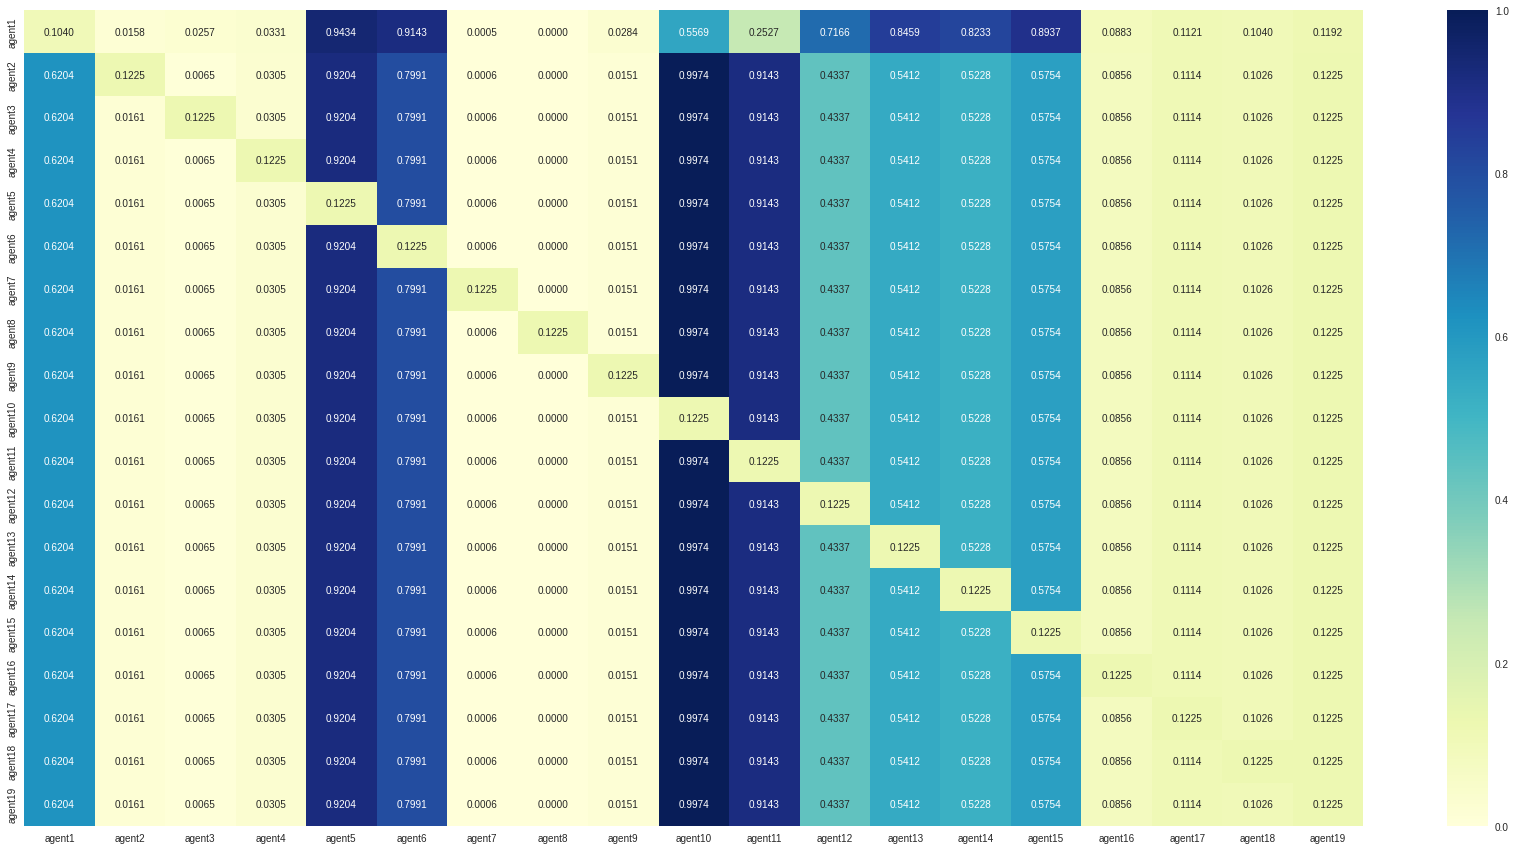

In [176]:
labels = [i for i in agents.keys() if i not in remove_agents]
plt.figure(figsize = (30,15))
ax = sns.heatmap(over_sampling_results, vmin=0, vmax=1, annot=True, fmt=".4f", xticklabels=labels, yticklabels=labels, cmap="YlGnBu")

In [177]:
# Calculation of the average of the model of each of the agents evaluated in other datasets
average_f1_score = dict()
for i, name in enumerate(agents.keys()):
    average_f1_score[name] = average(over_sampling_results[i])

for value in average_f1_score.values():
    print(value)

0.3462037610168005
0.3643170975477576
0.3648236306401732
0.3635592863618467
0.3167193944107498
0.32310428492972776
0.365134324379766
0.36516355602594613
0.3643695451366539
0.31266662895480835
0.3170429214282471
0.34233848203252687
0.33667689094307
0.3376458604641468
0.3348792059355574
0.36065747561620076
0.35930210493717407
0.3597654453646777
0.35871576941118627


### Analysis of the influence of each of the existing features in the dataset

*1st* Approach: The influence of each of the existing features in the dataset will be analyzed by excluding one feature at a time from one of the agents to verify how much the F1-Score values will be changed. First, an evaluation will be carried out with all components to establish a base value.

*2nd* Approach: Tests will be performed by classifying using only one feature at a time to avoid the large number of combinations generated by excluding one feature at a time. In this way, it is possible to verify which feature will have the best result by comparing the features with each other.

Agent 6 of the ToN-IOT dataset was chosen, as it already has a certain balance of data originally.

In [178]:
agent_feature_analysis = agents["agent6"]

X = agent_feature_analysis.drop(columns = ["Label"])
y = agent_feature_analysis.Label

X = preprocess(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

clf = SGDClassifier(random_state=seed, loss="log", class_weight="balanced")
parameters = {}

prep = StandardScaler() 
X_train = prep.fit_transform(X_train)
clf.fit(X_train, y_train)

X_test = prep.transform(X_test) 
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print(f1_score(y_test, y_pred, average="binary"))

0.9878067817188448


In [179]:
importance = clf.coef_

In [180]:
print(clf.n_features_in_)

38


In [181]:
importance_sum = int(np.sum(np.abs(importance[0]))) 
normalized_values = [float(abs(i))/importance_sum for i in importance[0]]

In [182]:
importance_values = dict()
for i,v in enumerate(normalized_values):
	importance_values[i] = abs(v)

In [183]:
dict(sorted(importance_values.items(), key=lambda item: item[1] , reverse=True))

{15: 0.20385104627731587,
 5: 0.13195640380826934,
 6: 0.09916838649037096,
 0: 0.06459446940187219,
 19: 0.05800207577738385,
 30: 0.04179491351593853,
 31: 0.035227075384161644,
 3: 0.03324451417438113,
 7: 0.031283391638124956,
 27: 0.031227182536283073,
 8: 0.030404599713747375,
 22: 0.028075865636127153,
 21: 0.027956015429363736,
 29: 0.027857858450137288,
 9: 0.026740159526794732,
 4: 0.024880195502926993,
 24: 0.01688866435546033,
 10: 0.016572024066193184,
 23: 0.01576601581324863,
 1: 0.013633302913737187,
 20: 0.012212957194014043,
 28: 0.011694252390749924,
 26: 0.011375626585641122,
 12: 0.010144367986268568,
 11: 0.008160334253466725,
 25: 0.006760595484282551,
 33: 0.006215025876807549,
 32: 0.006214821559503972,
 2: 0.0058459663085012395,
 13: 0.0026522829615390165,
 16: 0.0026522829615390165,
 14: 0.00145608853649308,
 17: 0.0013321636852693852,
 35: 0.0003615467732047513,
 34: 0.00022284053787620487,
 18: 5.732453252090243e-05,
 36: 0.0,
 37: 0.0}

In [184]:
feature_list = agent_feature_analysis.columns.to_list()[:-1]
features_to_delete = [feature_list[i] for i in importance_values if importance_values[i] < 0.05]
features_to_delete.append("Label")
print(features_to_delete)

['IN_BYTES', 'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS', 'SERVER_TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'DURATION_IN', 'DURATION_OUT', 'MIN_TTL', 'MAX_TTL', 'LONGEST_FLOW_PKT', 'SHORTEST_FLOW_PKT', 'MAX_IP_PKT_LEN', 'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES', 'RETRANSMITTED_IN_PKTS', 'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS', 'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT', 'NUM_PKTS_UP_TO_128_BYTES', 'NUM_PKTS_128_TO_256_BYTES', 'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES', 'NUM_PKTS_1024_TO_1514_BYTES', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT', 'ICMP_TYPE', 'ICMP_IPV4_TYPE', 'DNS_QUERY_ID', 'DNS_QUERY_TYPE', 'DNS_TTL_ANSWER', 'FTP_COMMAND_RET_CODE', 'Label']


## Evaluation of the coefficients for feature selection with weighting through the f1-score.

 - The models that obtained better results will have greater influence on the choice of features
 - An approach will be carried out that takes into account the data of each of the silos in the evaluation of the silos

---
Auxiliary Function

In [185]:
def sort_dict(d):
  return {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}

---

In [186]:
feature_selection_score = dict()
feature_selection_coefs = dict()
features_to_select = list() 

for name, agent in agents.items():
    X = agent.drop(columns=["Label"])
    y = agent.Label

    X = preprocess(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y) #stratified

    clf = SGDClassifier(random_state=seed, loss="log", class_weight="balanced")
    parameters = {}
    
    prep = StandardScaler() 
    
    X_train = prep.fit_transform(X_train)
    clf.fit(X_train, y_train)
    
    X_test = prep.transform(X_test) 
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:,1] # for ROC curve, get just for positive class "1"
    
    feature_selection_score[name] = f1_score(y_test, y_pred, average="binary")
    feature_selection_coefs[name] = clf.coef_[0]
    features_to_select = clf.n_features_in_

Eliminates outliers in relation to the F1-Score to prevent the model from being skewed

In [187]:
feature_score_sorted = sort_dict(feature_selection_score)
feature_score_sorted

{'agent18': 0.1428122050959421,
 'agent17': 0.1561158798283262,
 'agent19': 0.15828877005347594,
 'agent16': 0.1718185467683661,
 'agent7': 0.23040000000000002,
 'agent8': 0.7391593410652286,
 'agent4': 0.8643356643356643,
 'agent2': 0.9538461538461539,
 'agent5': 0.980069246362772,
 'agent6': 0.9878067817188448,
 'agent15': 0.9888761627593028,
 'agent14': 0.9905864738490057,
 'agent9': 0.9918032786885246,
 'agent12': 0.9940423719062413,
 'agent3': 0.9947948926922032,
 'agent1': 0.9952709699300392,
 'agent11': 0.9998806747301622,
 'agent10': 0.9999584461315657,
 'agent13': 1.0}

In [188]:
# Deleting the first 5 and last 5 agents
initial_size = len(feature_score_sorted.keys())
keys_to_delete = list()

for i, key in enumerate(feature_score_sorted.keys()):
    if (i < 5) or (i >= initial_size - 5): 
        keys_to_delete.append(key)

for key in keys_to_delete: 
    del feature_score_sorted[key]
    
feature_score_sorted

{'agent8': 0.7391593410652286,
 'agent4': 0.8643356643356643,
 'agent2': 0.9538461538461539,
 'agent5': 0.980069246362772,
 'agent6': 0.9878067817188448,
 'agent15': 0.9888761627593028,
 'agent14': 0.9905864738490057,
 'agent9': 0.9918032786885246,
 'agent12': 0.9940423719062413}

Weights the calculated values ​​of the coefficients with the performance of each of the agents.

In [189]:
for name, score in feature_score_sorted.items():
    abs_sum = int(np.sum(np.abs(feature_selection_coefs[name]))) 
    feature_selection_coefs[name] = [float(abs(i))/abs_sum for i in feature_selection_coefs[name]]
    
    for i, coef in enumerate(feature_selection_coefs[name]):
        feature_selection_coefs[name][i] = score * coef

Weighted sum of all participating agents to evaluate the most important features

In [192]:
weighted_coefs = list()
for _, coefs in feature_selection_coefs.items():
    if(len(weighted_coefs) == 0):
        weighted_coefs = coefs 
    else:
        for i, coef in enumerate(coefs):
            weighted_coefs[i] += coef

In [193]:
print(weighted_coefs)
weighted_abs_sum = int(np.sum(np.abs(weighted_coefs))) 
weighted_coefs = [float(abs(i))/weighted_abs_sum for i in weighted_coefs]
print(weighted_coefs)

[-3.64453720e+00 -1.38219383e+01  4.93864562e+01  3.89062216e+01
 -2.00906712e+01  4.99014323e+01  7.51160113e+01  1.40696028e+00
  6.90023358e+01 -3.20609156e+01 -4.73594673e+01 -9.00345190e+00
 -1.59427842e+01  1.85497656e+01 -1.28270093e+01  2.37044688e+01
  1.85497656e+01 -3.08099878e+00 -1.80634224e-01  1.11462818e+00
 -1.07848493e+00 -2.08499972e+01 -1.87749308e+01  4.25828683e+00
  4.23405217e+02  1.11576538e+02 -1.94479141e+01 -2.93660059e+01
 -8.43240813e+01 -6.44852828e+01  7.32726224e+01  3.59108646e+01
 -3.29697303e+01 -3.27149745e+01 -2.36686227e+00 -2.11502678e+00
 -1.30401988e+00 -4.86906667e-01]
[0.0024928435049302107, 0.009454130190468913, 0.03378006580097923, 0.02661164269318737, 0.013741909155948482, 0.03413230664237045, 0.051378940699281374, 0.0009623531327870563, 0.047197220102033914, 0.021929490801835403, 0.032393616455707326, 0.006158311832059368, 0.010904777171812196, 0.012687938188934492, 0.008773604178691467, 0.016213726960155644, 0.012687938188934492, 0.00210

Choosing the most important features of the model through a filter on the features with the highest value

In [194]:
features_to_select

38

In [195]:
weighted_coef_map = dict()

for i, feature in enumerate(feature_list): 
    weighted_coef_map[feature] = weighted_coefs[i]

weighted_coef_map = sort_dict(weighted_coef_map)

print(weighted_coef_map) 

{'DST_TO_SRC_SECOND_BYTES': 0.0001235528207337183, 'FTP_COMMAND_RET_CODE': 0.00033304149597763023, 'RETRANSMITTED_IN_PKTS': 0.000737677791563703, 'RETRANSMITTED_IN_BYTES': 0.0007623995755873089, 'DNS_TTL_ANSWER': 0.0008919424590784963, 'SERVER_TCP_FLAGS': 0.0009623531327870563, 'DNS_QUERY_TYPE': 0.001446666745729183, 'DNS_QUERY_ID': 0.0016189208410635938, 'SRC_TO_DST_SECOND_BYTES': 0.0021073863033669402, 'Unnamed: 0': 0.0024928435049302107, 'SRC_TO_DST_AVG_THROUGHPUT': 0.0029126448932558346, 'MIN_TTL': 0.006158311832059368, 'SHORTEST_FLOW_PKT': 0.008773604178691467, 'IN_BYTES': 0.009454130190468913, 'MAX_TTL': 0.010904777171812196, 'LONGEST_FLOW_PKT': 0.012687938188934492, 'MAX_IP_PKT_LEN': 0.012687938188934492, 'RETRANSMITTED_OUT_PKTS': 0.012841949907387476, 'NUM_PKTS_128_TO_256_BYTES': 0.013302266810386314, 'OUT_PKTS': 0.013741909155948482, 'RETRANSMITTED_OUT_BYTES': 0.014261283980451449, 'MIN_IP_PKT_LEN': 0.016213726960155644, 'NUM_PKTS_256_TO_512_BYTES': 0.02008618732638672, 'DURAT

In [196]:
sorted_feature_list = sort_dict(weighted_coef_map)
sorted_feature_list

{'DST_TO_SRC_SECOND_BYTES': 0.0001235528207337183,
 'FTP_COMMAND_RET_CODE': 0.00033304149597763023,
 'RETRANSMITTED_IN_PKTS': 0.000737677791563703,
 'RETRANSMITTED_IN_BYTES': 0.0007623995755873089,
 'DNS_TTL_ANSWER': 0.0008919424590784963,
 'SERVER_TCP_FLAGS': 0.0009623531327870563,
 'DNS_QUERY_TYPE': 0.001446666745729183,
 'DNS_QUERY_ID': 0.0016189208410635938,
 'SRC_TO_DST_SECOND_BYTES': 0.0021073863033669402,
 'Unnamed: 0': 0.0024928435049302107,
 'SRC_TO_DST_AVG_THROUGHPUT': 0.0029126448932558346,
 'MIN_TTL': 0.006158311832059368,
 'SHORTEST_FLOW_PKT': 0.008773604178691467,
 'IN_BYTES': 0.009454130190468913,
 'MAX_TTL': 0.010904777171812196,
 'LONGEST_FLOW_PKT': 0.012687938188934492,
 'MAX_IP_PKT_LEN': 0.012687938188934492,
 'RETRANSMITTED_OUT_PKTS': 0.012841949907387476,
 'NUM_PKTS_128_TO_256_BYTES': 0.013302266810386314,
 'OUT_PKTS': 0.013741909155948482,
 'RETRANSMITTED_OUT_BYTES': 0.014261283980451449,
 'MIN_IP_PKT_LEN': 0.016213726960155644,
 'NUM_PKTS_256_TO_512_BYTES': 0.020

Selecting the top 15 features values to test

In [197]:
features_to_delete = list()
initial_size = len(sorted_feature_list)

for i, feature in enumerate(sorted_feature_list): 
    if i <= (initial_size - 15):
        features_to_delete.append(feature)

features_to_delete.append('Label')

features_to_delete

['DST_TO_SRC_SECOND_BYTES',
 'FTP_COMMAND_RET_CODE',
 'RETRANSMITTED_IN_PKTS',
 'RETRANSMITTED_IN_BYTES',
 'DNS_TTL_ANSWER',
 'SERVER_TCP_FLAGS',
 'DNS_QUERY_TYPE',
 'DNS_QUERY_ID',
 'SRC_TO_DST_SECOND_BYTES',
 'Unnamed: 0',
 'SRC_TO_DST_AVG_THROUGHPUT',
 'MIN_TTL',
 'SHORTEST_FLOW_PKT',
 'IN_BYTES',
 'MAX_TTL',
 'LONGEST_FLOW_PKT',
 'MAX_IP_PKT_LEN',
 'RETRANSMITTED_OUT_PKTS',
 'NUM_PKTS_128_TO_256_BYTES',
 'OUT_PKTS',
 'RETRANSMITTED_OUT_BYTES',
 'MIN_IP_PKT_LEN',
 'NUM_PKTS_256_TO_512_BYTES',
 'DURATION_IN',
 'Label']

In [198]:
for name, agent in agents.items():
    X = agent.drop(columns=features_to_delete)
    y = agent.Label
    
    X = preprocess(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y) #stratified

    clf = SGDClassifier(random_state=seed, loss="log", class_weight="balanced")
    parameters = {}
    
    prep = StandardScaler() 

    X_train = prep.fit_transform(X_train)
    clf.fit(X_train, y_train)
    
    X_test = prep.transform(X_test) 
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:,1] # for ROC curve, get just for positive class "1"
    score = f1_score(y_test, y_pred, average="binary")
    print(name, set(y_test), set(y_pred), "{:.2f}".format(score))

agent1 {0, 1} {0, 1} 0.99
agent2 {0, 1} {0, 1} 0.62
agent3 {0, 1} {0, 1} 0.99
agent4 {0, 1} {0, 1} 0.51
agent5 {0, 1} {0, 1} 0.98
agent6 {0, 1} {0, 1} 0.98
agent7 {0, 1} {0, 1} 0.31
agent8 {0, 1} {0, 1} 0.77
agent9 {0, 1} {0, 1} 0.99
agent10 {0, 1} {0, 1} 1.00
agent11 {0, 1} {0, 1} 1.00
agent12 {0, 1} {0, 1} 0.99
agent13 {0, 1} {0, 1} 1.00
agent14 {0, 1} {0, 1} 0.99
agent15 {0, 1} {0, 1} 0.99
agent16 {0, 1} {0, 1} 0.15
agent17 {0, 1} {0, 1} 0.14
agent18 {0, 1} {0, 1} 0.15
agent19 {0, 1} {0, 1} 0.17


## Validation across silos using feature selection

In [214]:
sgd_feature = dict()
for agent in agents.keys():
    sgd_feature[agent] = SGDClassifier(n_jobs=-1, random_state=seed, loss="log", learning_rate='constant', eta0=lr, verbose=0)

In [231]:
fedavg = initialize_global_model(agents["agent1"], features_to_delete)

In [232]:
rounds_f1_score = dict() 

print("Federated Learning Started.")
for r in range(rounds):
    sample_size = random.randint(int(len(agents)/2), len(agents))
    applicable_agents = random.sample(list(agents.keys()), k=sample_size) # select random agents/silos

    applicable_models = []
    applicable_name = []

    # for calculating weighted average
    round_weights = []
    dataset_size = 0

    for name, agent in agents.items():
        if name not in applicable_agents: # check if agent/silos is in applicable_agents
            continue

        if name in remove_agents: # check if agent/silos is in remove_agents, if yes, jump (refer to FedAvg hyperparams)
            continue
        
        applicable_name.append(name)

        # Rebalance datasets to improve performance
        agent_balanced = rebalance_agent(agent)
        
        print(".", end=" ")
        X = agent_balanced.drop(columns=features_to_delete)
        y = agent_balanced.Label
      
        X = preprocess(X)

        X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=train_size, stratify=y) #stratified / random_state=seed
        X_train = prep.fit_transform(X_train)

        dataset_size += X_train.shape[0]

        sample_weights = compute_sample_weight('balanced', y=y_train)
        sgd_feature[name] = load_global_model(sgd_feature[name])
        sgd_feature[name] = train_local_agent(X_train, y_train, sgd_feature[name], epochs, sample_weights)
        round_weights.append(X_train.shape[0])
        applicable_models.append(sgd_feature[name])

    # Update global model (FedAvg) after each round
    round_weights = np.array(round_weights) / dataset_size # calculate weight based on actual dataset size

    try:
        update_global_model(applicable_models, round_weights)
    except:
        print("Error updating Global Model.")
    
     # Sends trained model to agents and evaluates f1-score per round
    for name, agent in agents.items():
        sgd_feature[name] = load_global_model(sgd_feature[name])
        """if(not name in rounds_f1_score):
            rounds_f1_score[name] = list()
        rounds_f1_score[name].append(test_agent_model(fedavg, agent))"""

Treinamento Federado Iniciado.
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

In [240]:
cross_validation_results = dict()

print("Cross Validation Analisys Started...")
for name, agent in agents.items():
    
    print(".", end="")
    if name in remove_agents:
            continue
            
    agent_balanced = rebalance_agent(agent) 
    
    X = agent_balanced.drop(columns=features_to_delete)
    y = agent_balanced.Label

    X = preprocess(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y) #stratified
    
    X_train = prep.fit_transform(X_train)
    X_test = prep.transform(X_test) 
    
    y_pred = sgd_feature[name].predict(X_test)
    
    cross_validation_results[name] = dict()
    cross_validation_results[name][name] = f1_score(y_test, y_pred, average="binary")
    
    print(name + " " + str(cross_validation_results[name][name]))
    
    for test_name, test_agent in agents.items():
        if test_name == name:
            continue
        
        X = test_agent.drop(columns=features_to_delete)
        y = test_agent.Label
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y) #stratified
        X_test = preprocess(X_test)
        X_test = prep.transform(X_test)
        
        y_pred = sgd_feature[name].predict(X_test)
        cross_validation_results[name][test_name] = f1_score(y_test, y_pred, average="binary")

Cross Validation Analisys Started...
.agent1 0.8292318767163461
.agent2 0.9763779527559054
.agent3 0.9517409756765391
.agent4 0.9648834919593042
.agent5 0.8748057006947957
.agent6 0.9485143485990011
.agent7 0.3191489361702127
.agent8 0.05486654855118021
.agent9 0.14690721649484537
.agent10 0.9841160220994475
.agent11 0.829389788293898
.agent12 0.927224261932304
.agent13 0.8425196850393701
.agent14 0.9681309216192936
.agent15 0.9830866807610994
.agent16 0.2021857923497268
.agent17 0.2821576763485477
.agent18 0.1446540880503145
.agent19 0.22559652928416482


In [236]:
feature_results = process_results(cross_validation_results, remove_agents)

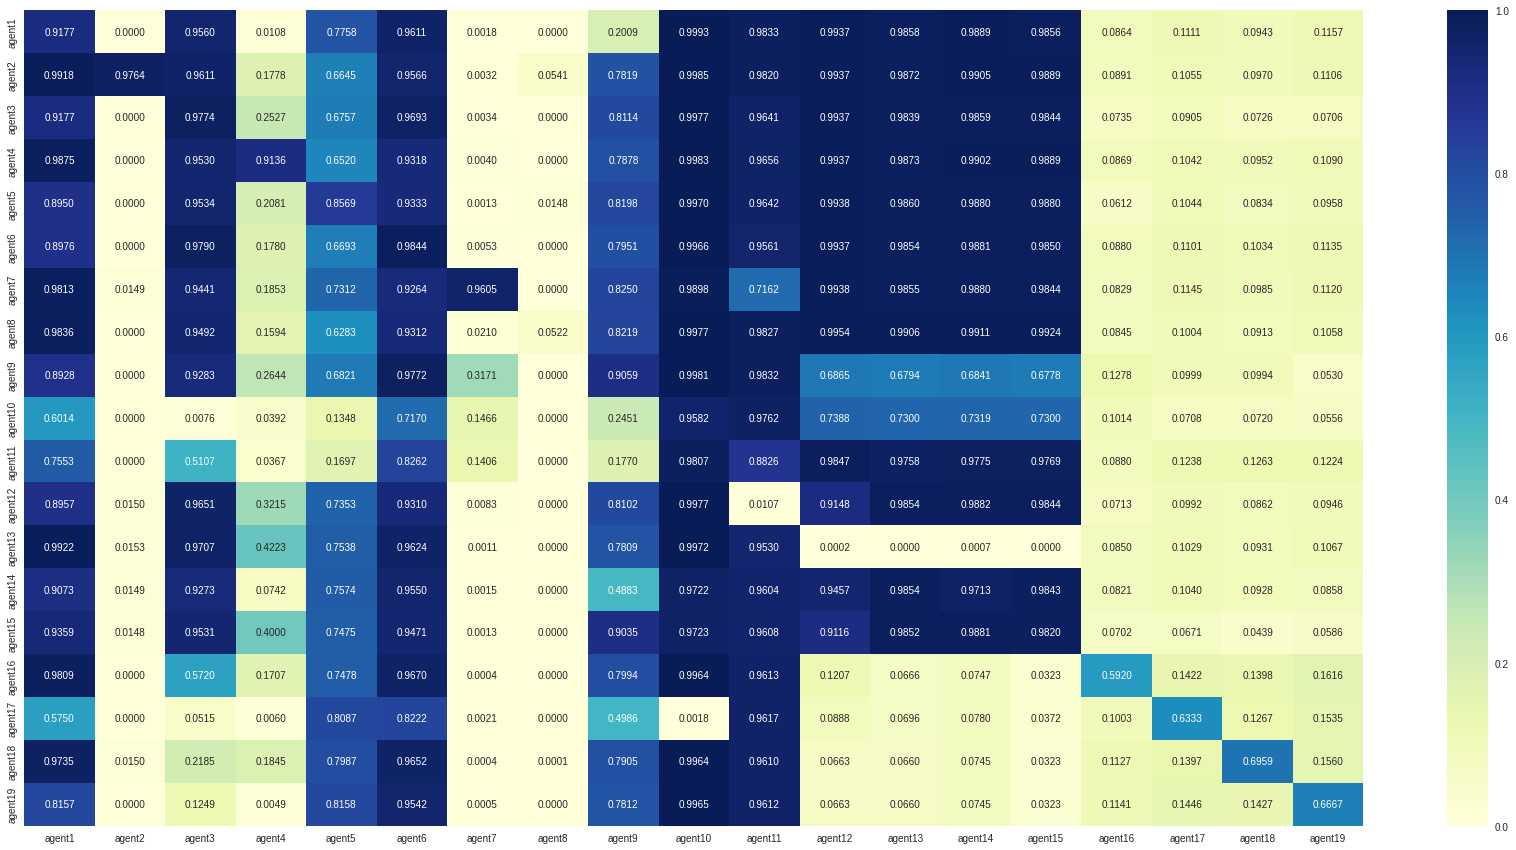

In [237]:
labels = [i for i in agents.keys() if i not in remove_agents]
plt.figure(figsize = (30,15))
ax = sns.heatmap(feature_results, vmin=0, vmax=1, annot=True, fmt=".4f", xticklabels=labels, yticklabels=labels, cmap="YlGnBu")

In [3]:
# Calculation of the average of the model of each of the agents evaluated in other datasets
average_f1_score = dict()
for i, name in enumerate(agents.keys()):
    average_f1_score[name] = average(feature_results[i])

for value in average_f1_score.values():
    print(value)

NameError: name 'agents' is not defined

## Validation with data that has never been seen by the model

In [211]:
validation_results = dict() 

for name in validation_agents.keys():
    validation_results[name] = dict()
    for test_name, test_agent in validation_agents.items():
        if test_name == name:
            continue
            
        agent = agents[name]
        agent_balanced = rebalance_agent(agent)
        X_scaler = agent_balanced.drop(columns=["Label"]) 
        X_scaler = preprocess(X_scaler)
        X_scaler = prep.fit_transform(X_scaler)
        
        X = test_agent.drop(columns = ["Label"])
        y = test_agent.Label
        
        X_test = preprocess(X)
        X_test = prep.transform(X_test)
        
        y_pred = fedavg.predict(X_test)
        
        validation_results[name][test_name] = f1_score(y, y_pred, average="binary")

In [241]:
feature_results = process_results(validation_results, remove_agents)

KeyError: 'agent1'